# Forcasting H0 constraints with lensed SNe
This notebook is meant to forecast future constraints with lensed supernovae to break the MST.


To run the notebook, the following software is required:
- hierArc: https://github.com/sibirrer/hierArc (version 1.1.0)
- lenstronomy: https://github.com/sibirrer/lenstronomy (version 1.9.0)
- corner: https://github.com/dfm/corner.py
- emcee: https://github.com/dfm/emcee

Author: Simon Birrer (sibirrer@gmail.com)


In [1]:
# import standard python modules
import numpy as np
import time
import corner
import emcee
import pickle
import copy
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# import lenstronomy and hierArc modules
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Plots import plot_util
from lenstronomy.Plots import chain_plot, lens_plot
from lenstronomy.Util import constants as const
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Util.data_util import magnitude2cps

from hierarc.Likelihood.anisotropy_scaling import AnisotropyScalingIFU
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

# matplotlib configs
from pylab import rc
rc('axes', linewidth=2)
rc('xtick',labelsize=12)
rc('ytick',labelsize=12)
rc('text', usetex=True)

# we set a random seed for reproduction of the specific results
np.random.seed(71)

# paths to save and load data products
path = os.getcwd()
dirname = os.path.dirname(path)

path2posteriors = os.path.join(dirname, 'Data')
path2sne_likelihood = os.path.join(dirname, 'Data', 'RomanWFIRST')


## Input truth hyperparmater model setting
Here we define the cosmological model and the population parameters to be constrainted in the hierarchical analysis. We make these parameter match the Pantheon inference with the same cosmological model, thus allowing us to use the Pantheon sample in our forecast as an option.

In [2]:
# ===============
# Input cosmology
# ===============

kwargs_cosmo_true = {'h0': 70, 'om': 0.3}  # cosmological model of the forecast for a flat LCDM model

# create astropy.cosmology instance of input cosmology
from astropy.cosmology import FlatLambdaCDM
# Flat LCDM cosmology
cosmo_true = FlatLambdaCDM(H0=kwargs_cosmo_true['h0'], Om0=kwargs_cosmo_true['om'])


# ==========================================
# Input deflector population hyperparameters
# ==========================================

lambda_int_true_mean = 1.  # input truth sample mean internal MST transform
lambda_int_true_sigma = .03  # input truth sample 1-sigma scatter of internal MST transform

lambda_int_distribution = 'GAUSSIAN'  # 'delta' #'GAUSSIAN'  # single-valued or Gaussian distribution in the internal MST transform on top of a power-law model
kwargs_lens_true = {'lambda_mst': lambda_int_true_mean}
if lambda_int_distribution == 'GAUSSIAN':
    kwargs_lens_true['lambda_mst_sigma'] = lambda_int_true_sigma


def draw_lambda_int_true():
    """
    draw realizations of lambda_int for the input truth distribution
    """
    if lambda_int_distribution == 'delta':
        return lambda_int_true_mean
    else:
        return np.random.normal(lambda_int_true_mean, lambda_int_true_sigma)


# ==============================================
# Input line-of-sight population hyperparameters
# ==============================================

kappa_ext_mean_true = 0  # population mean of the external convergence
kappa_ext_sigma_true = 0.025  # 1-sigma Gaussian scatter in the distribution of external convergences for individual lenses

kappa_ext_distribution = 'GAUSSIAN'  # 'delta' #'GAUSSIAN'  # single-valued or Gaussian distribution in the line-of-sight convergence

kwargs_lens_true['kappa_ext'] = kappa_ext_mean_true
if kappa_ext_distribution == 'GAUSSIAN':
    kwargs_lens_true['kappa_ext_sigma'] = kappa_ext_sigma_true
    


def draw_kappa_ext_true():
    """
    draw realizations of lambda_int for the input truth distribution
    """
    if kappa_ext_distribution == 'delta':
        return kappa_ext_mean_true
    else:
        return np.random.normal(kappa_ext_mean_true, kappa_ext_sigma_true)

def draw_lambda_tot_true():
    """
    draw realization of lambda_tot, the combined MST transform of internal and external MST
    """
    lambda_int_draw = draw_lambda_int_true()
    kappa_ext_draw = draw_kappa_ext_true()
    return (1 - kappa_ext_draw) * lambda_int_draw


# =========================
# SNe population parameters
# =========================

# we add the apparent source magnitude at z=0.1 (pivot normalization) (mean of Gaussian distribution in astronomical magnitudes)
z_apparent_m_anchor = 0.1
# we use the mean inferred apparent magnitude of the Pantheon sample
apparent_m_p_true = 18.965677764035803  # apparent magnitude (mean in magnitude) at pivot redshift, this is the value inferred by the Pantheon analysis
mu_sne_true = apparent_m_p_true
sigma_sne_true = 0.1  # 1-sigma with of Gaussian in astronomical magnitude

kwargs_source_true = {'mu_sne': mu_sne_true, 'sigma_sne': sigma_sne_true}

def draw_mag_source(z_source):
    """
    draw an apparent unlensed astronomical magnitude of a SN at given redshift
    """
    # draw apparent magnitude as at pivot redshift
    mag_source_pivot = np.random.normal(mu_sne_true, sigma_sne_true)
    
    # compute relative luminosity distance between pivot redshift and source redshift
    angular_diameter_distance_source = cosmo_true.angular_diameter_distance(z_source).value
    lum_dist_source = (5 * np.log10((1 + z_source) * (1 + z_source) * angular_diameter_distance_source))

    ang_dist_pivot = cosmo_true.angular_diameter_distance(z_apparent_m_anchor).value
    lum_dist_pivot = (5 * np.log10((1 + z_apparent_m_anchor) * (1 + z_apparent_m_anchor) * ang_dist_pivot))
    delta_mag = lum_dist_source - lum_dist_pivot
    
    mag_source = mag_source_pivot + delta_mag
    return mag_source


## Sampling configurations and bounds
Here we set the lower and upper limits, as well as the initial sampling state for the subsequent analyses. We set the starting point, for convenience, to be the input truth parameters.

In [3]:
# ==========================
# COSMOLOGY SAMPLING OPTIONS
# ==========================

# currently supported models within hierArc: 'FLCDM', "FwCDM", "w0waCDM", "oLCDM"
# parameters are: 'h0', 'om', 'ok', 'w', 'w0', 'wa'

# we are sampling a flat LCDM cosmology with parameters 'h0' and 'om' as an example
cosmology = 'FLCDM'

kwargs_lower_cosmo = {'h0': 0, 'om': 0.05}  # lower bounds on cosmology parameters
kwargs_upper_cosmo = {'h0': 150, 'om': 0.5}  # upper bounds on cosmology parameters
kwargs_cosmo_start_mean = {'h0': 70, 'om': 0.3}  # mean start particles
kwargs_cosmo_start_sigma = {'h0': 10, 'om': 0.1}  # width of start particles


# initial start and hard bounds for source and lens hyper parameters:

kwargs_source_start_mean = kwargs_source_true  # mean start particles, for simplicity we initalize it at the input truth
kwargs_source_start_sigma = {'mu_sne': 0.1, 'sigma_sne': 0.05}  # width of start particles
kwargs_lower_source = {'mu_sne': apparent_m_p_true-20, 'sigma_sne': 0.}  # lower bounds on cosmology parameters
kwargs_upper_source = {'mu_sne': apparent_m_p_true+20, 'sigma_sne': 2}  # upper bounds on cosmology parameters

kwargs_lens_start_mean = kwargs_lens_true  # mean start particles, for simplicity we initalize it at the input truth
kwargs_lens_start_sigma = {'lambda_mst': 0.1, 'lambda_mst_sigma': 0.03, 'kappa_ext': 0.01, 'kappa_ext_sigma': 0.01}
kwargs_lower_lens = {'lambda_mst': 0.5, 'lambda_mst_sigma': 0, 'kappa_ext': -0.2, 'kappa_ext_sigma': 0}
kwargs_upper_lens = {'lambda_mst': 1.5, 'lambda_mst_sigma': 0.5, 'kappa_ext': 0.2, 'kappa_ext_sigma': 0.2}

kwargs_mean_start = {'kwargs_cosmo': kwargs_cosmo_start_mean, 'kwargs_source': kwargs_source_start_mean, 'kwargs_lens': kwargs_lens_start_mean}
kwargs_sigma_start = {'kwargs_cosmo': kwargs_cosmo_start_sigma, 'kwargs_source': kwargs_source_start_sigma, 'kwargs_lens': kwargs_lens_start_sigma}

## SNe-only analysis

We are using the Pantheon sample to constrain the relative expansion history with SN Ia's and to determin the apparent magnitudes of the population of supernovae. We also define a mock sample that is more precise in the expected constraints than the Pantheon sample to mimique the precision of future SNe samples, such as from the Roman observatory.

The Pantheon sample likelihood is directly available in hierArc and includes intrinsic scatter in the SNe population, while our mock sample separates measurement and systematic uncertainties from the intrinsic scatter.

In [4]:

# ========================================================================
# Create mock sample of unlensed SNe (more precise than Pantheon or Roman)
# ========================================================================

re_draw_mock_sne = False
mock_likelihood_file = os.path.join(path2sne_likelihood, 'mock_sne.pkl')

num_sne_field = 1000  # number of SNe
zcmb = np.linspace(start=0.01, stop=0.8, num=num_sne_field)  # redshift of the SNe
zhel = zcmb  # we ignore the relative velocity of the heliosphere for this forecast

cov_error_sne = 0.001  # fully covariant uncertainty in the SNe sample (calibration and systematics)[1-sigma in astronomical magnitudes]
flux_error_sne = 0.05  # uncorrelated flux measurement errors [1-sigma in astronomical magnitudes]

# compute luminosity distances
angular_diameter_distances = cosmo_true.angular_diameter_distance(zcmb).value
lum_dists_true = (5 * np.log10((1 + zhel) * (1 + zcmb) * angular_diameter_distances))

# subtract (in magintude space) the pivot luminosity distance
angular_diameter_distance_pivot = cosmo_true.angular_diameter_distance(z_apparent_m_anchor).value
lum_dist_pivot = (5 * np.log10((1 + z_apparent_m_anchor) * (1 + z_apparent_m_anchor) * angular_diameter_distance_pivot))

# define error covariance, with both a fully covariant systematic term, as well as an independent measurement term
cov_mag = np.ones((num_sne_field, num_sne_field)) * cov_error_sne**2 + np.diag(np.ones(num_sne_field) * flux_error_sne**2)  # full covariance matrix of systematics
cov_mag_measure = cov_mag + np.diag(np.ones(num_sne_field) * sigma_sne_true**2)
mags = mu_sne_true + lum_dists_true - lum_dist_pivot
# draw from scatter in multivariate normal distribution based on the covariance matrix
mag_mean = np.random.multivariate_normal(mags, cov_mag_measure)

if re_draw_mock_sne:
    kwargs_sne_likelihood_mock = {'mag_mean': mag_mean, 'cov_mag': cov_mag, 'zhel': zhel, 'zcmb': zcmb}
    
    dbfile = open(mock_likelihood_file, 'ab')
    pickle.dump(kwargs_sne_likelihood_mock, dbfile)                     
    dbfile.close()
    
else:
    dbfile = open(mock_likelihood_file, 'rb')     
    kwargs_sne_likelihood_mock = pickle.load(dbfile)
    dbfile.close()




# ===============================================
# Prior mimicing high-precision future SNe sample
# ===============================================



class CustomPrior(object):
    def __init__(self, future_sne=False):
        self._future_sne = future_sne
        self.om_mean = kwargs_cosmo_true['om']
        self.sigma_om = 0.005  # thight prior on Om based on future SNe sample flat LCDM constraints 
        
        self.m_p_mean = kwargs_source_true['mu_sne']
        self.m_p_sigma = 0.001
        
        self.m_p_sigma_mean = kwargs_source_true['sigma_sne']
        self.m_p_sigma_sigma = 0.001
        
        
    def __call__(self, kwargs_cosmo, kwargs_lens, kwargs_kin, kwargs_source):
        return self.log_likelihood(kwargs_cosmo, kwargs_lens, kwargs_kin, kwargs_source)
    
    # not needed anymore for Pantheon sampling
    def log_likelihood(self, kwargs_cosmo, kwargs_lens, kwargs_kin, kwargs_source):

        logL = 0
        if self._future_sne is True:
            om = kwargs_cosmo.get('om', self.om_mean)
            logL += -(om - self.om_mean)**2 / self.sigma_om**2 / 2
            
            m_p = kwargs_source.get('mu_sne', self.m_p_mean)
            logL += -(m_p - self.m_p_mean)**2 / self.m_p_sigma**2 / 2
            
            m_p_sigma = kwargs_source.get('sigma_sne', self.m_p_sigma_mean)
            logL += -(m_p_sigma - self.m_p_sigma_mean)**2 / self.m_p_sigma_sigma**2 / 2
        return logL


In [5]:
# ===============================
# importing Roman/WFIRST forecast
# ===============================

re_draw_roman_sne = False  # re-draws realization of Roman forecast data vector
roman_likelihood_file = os.path.join(path2sne_likelihood, 'roman_sne.pkl')

from hierarc.Likelihood.SneLikelihood.sne_likelihood_from_file import read_covariance_matrix

roman_likelihood = os.path.join(path2sne_likelihood, 'lcparam_WFIRST_G10.txt')
roman_binned = np.loadtxt(roman_likelihood)

z_cmb = roman_binned[:, 1]
z_hel = roman_binned[:, 2]
mb = roman_binned[:, 4]
dmb = roman_binned[:, 5]

n_bins_roman = len(z_cmb)

roman_cov_file = os.path.join(path2sne_likelihood, 'sys_WFIRST_G10_0.txt')
cov_roman = read_covariance_matrix(roman_cov_file, n_bins_roman)

# add uncorrelated magnitude errors
cov_roman_diag = cov_roman.diagonal()
np.fill_diagonal(cov_roman, cov_roman_diag + dmb**2)


# compute luminosity distances

angular_diameter_distances = cosmo_true.angular_diameter_distance(z_cmb).value
lum_dists_true = (5 * np.log10((1 + z_hel) * (1 + z_cmb) * angular_diameter_distances))

# subtract (in magintude space) the pivot luminosity distance
angular_diameter_distance_pivot = cosmo_true.angular_diameter_distance(z_apparent_m_anchor).value
lum_dist_pivot = (5 * np.log10((1 + z_apparent_m_anchor) * (1 + z_apparent_m_anchor) * angular_diameter_distance_pivot))

mags = mu_sne_true + lum_dists_true - lum_dist_pivot

# draw from scatter in multivariate normal distribution based on the covariance matrix
mag_mean = np.random.multivariate_normal(mags, cov_roman)

if re_draw_roman_sne:
    kwargs_sne_likelihood_roman = {'mag_mean': mag_mean, 'cov_mag': cov_roman, 'zhel': z_hel, 'zcmb': z_cmb,
                                   'no_intrinsic_scatter': True}
    
    dbfile = open(roman_likelihood_file, 'ab')
    pickle.dump(kwargs_sne_likelihood_roman, dbfile)                     
    dbfile.close()
    
else:
    dbfile = open(roman_likelihood_file, 'rb')     
    kwargs_sne_likelihood_roman = pickle.load(dbfile)
    dbfile.close()
    
    

In [6]:


# =========================================================
# Setting bounds and sampling options for SNe-only sampling
# =========================================================


kwargs_bounds_sne = {'kwargs_lower_cosmo': kwargs_lower_cosmo,
                     'kwargs_upper_cosmo': kwargs_upper_cosmo,
                     'kwargs_fixed_cosmo': {},  # if we wanted, we could fix H0 as it is irrelevant for the sampling of unlensed SNe parameters
                     'kwargs_lower_source': kwargs_lower_source,
                     'kwargs_upper_source': kwargs_upper_source,
                     'kwargs_fixed_source': {'sigma_sne': 0},  # we fix the scatter =0 as the Pantheon sample covariance includes intrinsic scatter
                }

kwargs_bounds_sne_mock = {'kwargs_lower_cosmo': kwargs_lower_cosmo,
                     'kwargs_upper_cosmo': kwargs_upper_cosmo,
                     'kwargs_fixed_cosmo': {},  # if we wanted, we could fix H0 as it is irrelevant for the sampling of unlensed SNe parameters
                     'kwargs_lower_source': kwargs_lower_source,
                     'kwargs_upper_source': kwargs_upper_source,
                     'kwargs_fixed_source': {},  # for our mock, we explicitly did not include the intrinsic scatter in the covariance matrix and let it be constrained by the likelihood
                }


mcmc_sampler_sne_pantheon = MCMCSampler(kwargs_likelihood_list=[], cosmology=cosmology, 
                               sne_likelihood='Pantheon', # we are using the Pantheon sample as the likelihood
                               sne_apparent_m_sampling=True, # we sample the apparent magnitude (this is optional, to test for incorporanting Sne magnitudes in the strong lensing analysis)
                               sne_distribution='NONE',  # we do not add distribution parameter of the apparent magnitudes at fixed redshift (becomes only relevant for the SL analysis)
                               kwargs_bounds=kwargs_bounds_sne,
                               z_apparent_m_anchor=z_apparent_m_anchor,
                               interpolate_cosmo=True, num_redshift_interp=100)

# Roman forecast without adopting parameter values
mcmc_sampler_sne_roman_original = MCMCSampler(kwargs_likelihood_list=[], cosmology=cosmology, 
                               sne_likelihood='Roman_forecast', # we are using the Pantheon sample as the likelihood
                               sne_apparent_m_sampling=True, # we sample the apparent magnitude (this is optional, to test for incorporanting Sne magnitudes in the strong lensing analysis)
                               sne_distribution='NONE',  # we do not add distribution parameter of the apparent magnitudes at fixed redshift (becomes only relevant for the SL analysis)
                               kwargs_bounds=kwargs_bounds_sne,
                               z_apparent_m_anchor=z_apparent_m_anchor,
                               interpolate_cosmo=True, num_redshift_interp=100)

# adopted parameter values
mcmc_sampler_sne_roman = MCMCSampler(kwargs_likelihood_list=[], cosmology=cosmology, 
                               sne_likelihood='CUSTOM', # we are using the Pantheon sample as the likelihood
                               sne_apparent_m_sampling=True, # we sample the apparent magnitude (this is optional, to test for incorporanting Sne magnitudes in the strong lensing analysis)
                               sne_distribution='NONE',  # we do not add distribution parameter of the apparent magnitudes at fixed redshift (becomes only relevant for the SL analysis)
                               kwargs_sne_likelihood=kwargs_sne_likelihood_roman,
                               kwargs_bounds=kwargs_bounds_sne,
                               z_apparent_m_anchor=z_apparent_m_anchor,
                               interpolate_cosmo=True, num_redshift_interp=100)

mcmc_sampler_sne_mock = MCMCSampler(kwargs_likelihood_list=[], cosmology=cosmology, 
                               sne_likelihood='CUSTOM', # we are using the Pantheon sample as the likelihood
                               sne_apparent_m_sampling=True, # we sample the apparent magnitude (this is optional, to test for incorporanting Sne magnitudes in the strong lensing analysis)
                               sne_distribution='GAUSSIAN',  # we do not add distribution parameter of the apparent magnitudes at fixed redshift (becomes only relevant for the SL analysis)
                               kwargs_sne_likelihood=kwargs_sne_likelihood_mock,
                               kwargs_bounds=kwargs_bounds_sne_mock,
                               z_apparent_m_anchor=z_apparent_m_anchor,
                               interpolate_cosmo=True, num_redshift_interp=100)


mcmc_sampler_sne_future = MCMCSampler(kwargs_likelihood_list=[], cosmology=cosmology, 
                               sne_likelihood=None, # we are using the Pantheon sample as the likelihood
                               sne_apparent_m_sampling=True, # we sample the apparent magnitude (this is optional, to test for incorporanting Sne magnitudes in the strong lensing analysis)
                               sne_distribution='GAUSSIAN',  # we do not add distribution parameter of the apparent magnitudes at fixed redshift (becomes only relevant for the SL analysis)
                               custom_prior=CustomPrior(future_sne=True),
                               kwargs_bounds=kwargs_bounds_sne,
                               z_apparent_m_anchor=z_apparent_m_anchor,
                               interpolate_cosmo=True, num_redshift_interp=100)

# =============================
# EMCEE SAMPLING CONFIGURATIONS
# =============================

# file name of chains. ATTENTION!!! Do not store them in version control and chose a different path!

# Set up the backend
# Don't forget to clear it in case the file already exists
#backend_sne = emcee.backends.HDFBackend(filename_sne)
    
# these configs are such that you can locally execute it in few hours, not meant to provide converged chains!
kwargs_emcee_sne = {'n_walkers': 100,  # number of walkers
                'n_run': 400,  # number of iterations saved in the file
                'n_burn': 400,  # number of iterations as burn-in prior to start saving the chain
                'pool': None,  # (option) emcee pool for multi-threading or MPI, see e.g. emcee documentation or usage in lenstronomy
                'continue_from_backend': False,  # boolean, if True, continues sampling the emcee chain from a backend (if exists), otherwise deletes previous chains and starts from scratch
                'kwargs_mean_start': kwargs_mean_start,  # starting positions as configured
                'kwargs_sigma_start': kwargs_sigma_start,  # starting position as configured
                #'backend': backend_sne,
               }

In [7]:
run_pantheon = False
run_mock_sne = False
run_future_sne = False
run_roman_sne_original = False
run_roman_sne = False

# ==============================
# run sampling for Pantheon data
# ==============================

backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'sne_pantheon_only.h5'))

if run_pantheon:
    mcmc_samples_sne_pantheon, log_prob_sne_pantheon = mcmc_sampler_sne_pantheon.mcmc_emcee(backend=backend, **kwargs_emcee_sne)
else:
    n_burn = kwargs_emcee_sne['n_burn']
    mcmc_samples_sne_pantheon = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_sne_pantheon = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

index_mag = 2  # index of mu_sne magnitude parameter in the SNe-only fit
apparent_m_z_pantheon = np.mean(mcmc_samples_sne_pantheon[:, index_mag])


# ======================
# run sampling for Roman 
# ======================

backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'sne_roman_only.h5'))

if run_roman_sne:
    mcmc_samples_sne_roman, log_prob_sne_roman = mcmc_sampler_sne_roman.mcmc_emcee(backend=backend, **kwargs_emcee_sne)
else:
    n_burn = kwargs_emcee_sne['n_burn']
    mcmc_samples_sne_roman = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_sne_roman = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

    
backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'sne_roman_original_only.h5'))

if run_roman_sne_original:
    mcmc_samples_sne_roman_original, log_prob_sne_roman_original = mcmc_sampler_sne_roman_original.mcmc_emcee(backend=backend, **kwargs_emcee_sne)
else:
    n_burn = kwargs_emcee_sne['n_burn']
    mcmc_samples_sne_roman_original = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_sne_roman_original = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

# =====================
# run sampling for mock 
# =====================

backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'sne_mock_only.h5'))

if run_mock_sne:
    mcmc_samples_sne_mock, log_prob_sne_mock = mcmc_sampler_sne_mock.mcmc_emcee(backend=backend, **kwargs_emcee_sne)
else:
    n_burn = kwargs_emcee_sne['n_burn']
    mcmc_samples_sne_mock = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_sne_mock = backend.get_log_prob(discard=n_burn, flat=True, thin=1)


# ==============================================
# run sampling with priors for future SNe sample 
# ==============================================

backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'sne_future_only.h5'))
if run_future_sne:
    mcmc_samples_sne_future, log_prob_sne_future = mcmc_sampler_sne_future.mcmc_emcee(backend=backend, **kwargs_emcee_sne)
else:
    n_burn = kwargs_emcee_sne['n_burn']
    mcmc_samples_sne_future = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_sne_future = backend.get_log_prob(discard=n_burn, flat=True, thin=1)




/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/corner/core.py:660: UserWarning: The following kwargs were not used by contour: 'color'
  **contourf_kwargs,
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


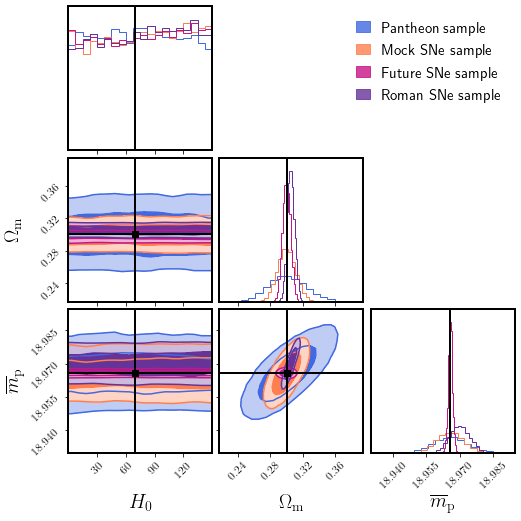

In [8]:
# ===========================================================================
# joint plotting of overlapping posteriors of Pantheon and future mock sample
# ===========================================================================

save_plot = False  # (only for paper writting set =True)

truths = mcmc_sampler_sne_pantheon.param.kwargs2args(kwargs_cosmo=kwargs_cosmo_true, kwargs_lens=kwargs_lens_true, kwargs_source=kwargs_source_true)

param_names_sne_pantheon = mcmc_sampler_sne_pantheon.param_names(latex_style=False)
param_names_sne_mock = mcmc_sampler_sne_mock.param_names(latex_style=False)

mcmc_samples_sne_mock_short = np.zeros((len(mcmc_samples_sne_mock[:, 0]), len(mcmc_samples_sne_pantheon.T)))

# here we select only the subset of parameters common to both samplings (i.e. without intrinsic scatter)

j = 0
for i, param in enumerate(param_names_sne_mock):
    if param in param_names_sne_pantheon:
        mcmc_samples_sne_mock_short[:, j] = mcmc_samples_sne_mock[:, i]
        if param == 'om':
            mcmc_samples_sne_mock_short[:, j] *= kwargs_cosmo_true['om']/np.mean(mcmc_samples_sne_mock_short[:, j])
        elif param == 'mu_sne':
            mcmc_samples_sne_mock_short[:, j] *= kwargs_source_true['mu_sne']/np.mean(mcmc_samples_sne_mock_short[:, j])
        j += 1
    else:
        pass


color_list = ['royalblue', 'coral', 'mediumvioletred', 'rebeccapurple', 'steelblue', 'crimson', 'g', 'purple', 'orange', 'r', 'k']
levels = [0.68,0.95]
alpha = 0.8
#extents = [[60, 80], [0.2, 0.4], [0.8, 1.2], [0, 0.1], [mu_sne_true-0.05, mu_sne_true+0.05]]

kwargs_corner = {'bins': 20, 'alpha': 0.2, 'smooth': 0.9, 'smooth1d': None, 
                 'levels': levels, 'truths': truths, 'truth_color': 'k',
                 'fill_contours': True, 'plot_datapoints': False,}
                 #'range': extents}


fig = corner.corner(mcmc_samples_sne_pantheon, labels=mcmc_sampler_sne_pantheon.param_names(latex_style=True),
                    color=color_list[0],
                    #range=extents,
                    #show_titles=True,
                    hist_kwargs= {'density': True, 'color': color_list[0]},
                    #title_kwargs=dict(fontsize=15),
                    label_kwargs=dict(fontsize=20),
                    contourf_kwargs={'color': color_list[0]},
                    **kwargs_corner)

fig = corner.corner(mcmc_samples_sne_mock_short, color=color_list[1], fig=fig,
                    hist_kwargs= {'density': True, 'color': color_list[1]}, **kwargs_corner)

fig = corner.corner(mcmc_samples_sne_future, color=color_list[2], fig=fig,
                    hist_kwargs= {'density': True, 'color': color_list[2]}, **kwargs_corner)

fig = corner.corner(mcmc_samples_sne_roman, color=color_list[3], fig=fig,
                    hist_kwargs= {'density': True, 'color': color_list[3]}, **kwargs_corner)


ax = fig.axes[2]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

patch_1 = mpatches.Patch(color=color_list[0], label='Pantheon sample', alpha=alpha)
patch_2 = mpatches.Patch(color=color_list[1], label='Mock SNe sample', alpha=alpha)
patch_3 = mpatches.Patch(color=color_list[2], label='Future SNe sample', alpha=alpha)
patch_4 = mpatches.Patch(color=color_list[3], label='Roman SNe sample', alpha=alpha)

ax.legend(handles=[patch_1, patch_2, patch_3, patch_4], fontsize=15, handlelength=0.9, loc=1, frameon=False)

if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/sne_only_posteriors.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

fig.show()




In [9]:
# ===================================================================
# make table with comparison of Pantheon and future sample posteriors
# ===================================================================


panthon_om_string = plot_util.result_string(mcmc_samples_sne_pantheon[:, 1]/np.mean(mcmc_samples_sne_pantheon[:, 1])*kwargs_cosmo_true['om'], weights=None, title_fmt=".3f", label=None)
roman_om_string = plot_util.result_string(mcmc_samples_sne_roman[:, 1]/np.mean(mcmc_samples_sne_roman[:, 1])*kwargs_cosmo_true['om'], weights=None, title_fmt=".3f", label=None)

panthon_mp_string = plot_util.result_string(mcmc_samples_sne_pantheon[:, 2]/np.mean(mcmc_samples_sne_pantheon[:, 2])*mu_sne_true, weights=None, title_fmt=".3f", label=None)
roman_mp_string = plot_util.result_string(mcmc_samples_sne_roman[:, 2]/np.mean(mcmc_samples_sne_roman[:, 2])*mu_sne_true, weights=None, title_fmt=".3f", label=None)


print(r'\hline')
print(r'Scenario & $\Omega_{\rm m}$ & $\overline{m}_{\rm p}$ & $\sigma(m_{\rm p})$  \\ ')
print(r'\hline \hline')
print(r'\textsc{Pantheon} & ' + panthon_om_string + ' & ' + panthon_mp_string + ' & $=0.1$ \\\ ')
print(r'\textsc{Roman} & ' + roman_om_string + ' & ' + roman_mp_string + ' & $=0.1$ \\\ ')
print(r'\hline')



\hline
Scenario & $\Omega_{\rm m}$ & $\overline{m}_{\rm p}$ & $\sigma(m_{\rm p})$  \\ 
\hline \hline
\textsc{Pantheon} & ${0.299}_{-0.022}^{+0.023}$ & ${18.966}_{-0.008}^{+0.008}$ & $=0.1$ \\ 
\textsc{Roman} & ${0.300}_{-0.004}^{+0.005}$ & ${18.966}_{-0.004}^{+0.005}$ & $=0.1$ \\ 
\hline


## Lens model posteriors

In this part we specify the lens models used and mimic uncertainties in the lens model posteriors as provided by imaging data.
The result of this part are uncertainties on the lens magnification and Fermat potential and full covariances among those posteriors for three different image configurations.


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:77: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


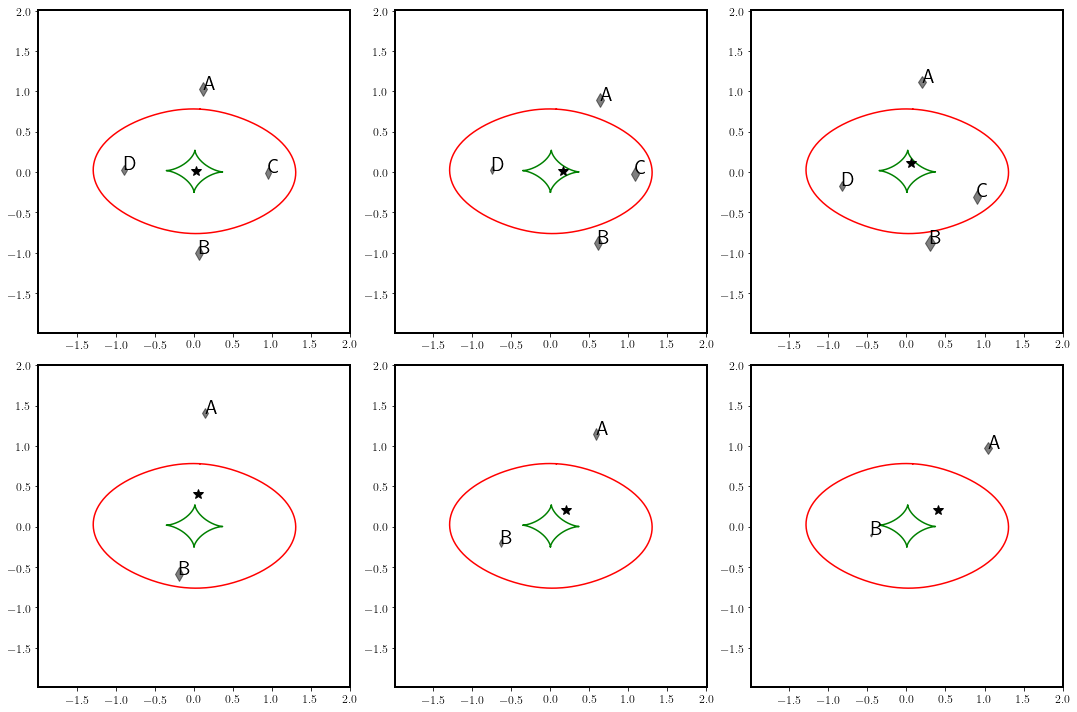

In [10]:
# ===================================================
# Lens model and uncertainties from imaging modelling
# ===================================================

# Here we define Einstein radius, power-law slope and half light radius of the deflector - and their uncertainties. 
# In this forecast, for simplicity, we assume that all lenses are identical in these parameters to re-utilize the dimensionless kinematics prediction for all lenses.

# lens and light model parameters and uncertainties (used for kinematic modeling uncertainties)
theta_E_true, theta_E_error = 1.0, 0.02  # Einstein radius
gamma_true, gamma_error = 2.0, 0.03  # power-law slope of the mass profile
e1_true, e1_error = 0.3, 0.01  # eccentricity of deflector
e2_true, e2_error = -0.01, 0.01  # eccentricity of deflector
center_x_true, center_x_error = 0, 0.01  # center of deflector
center_y_true, center_y_error = 0, 0.01 # center of deflector
gamma1_true, gamma1_error = 0.05, 0.01  # external shear
gamma2_true, gamma2_error = 0., 0.01  # external shear

astrometric_precision = 0.005  # astrometric precision of the images of the multiply lensed SNe in arc seconds

# define lens model and source position
kwargs_lens_pl_true = [{'theta_E': theta_E_true, 'gamma': gamma_true, 
                        'e1': e1_true, 'e2': e2_true, 
                        'center_x': center_x_true, 'center_y': center_y_true},
                       {'gamma1': gamma1_true, 'gamma2': gamma2_true}]


# ========================================================================
# defining soure positions to lead to cusp, fold, and cross configurations
# ========================================================================

kwargs_ps_cross = [{'ra_source': 0.02, 'dec_source': 0}]  # cross
kwargs_ps_cusp = [{'ra_source': 0.15, 'dec_source': 0}]  # cusp
kwargs_ps_fold = [{'ra_source': 0.05, 'dec_source': 0.1}]  # fold
kwargs_ps_double1 = [{'ra_source': 0.05, 'dec_source': 0.4}]  # double #1
kwargs_ps_double2 = [{'ra_source': 0.2, 'dec_source': 0.2}]  # double #1
kwargs_ps_double3 = [{'ra_source': 0.4, 'dec_source': 0.2}]  # double #1


# =========================================
# illustrate image configurations in figure
# =========================================

lens_model_list = ['EPL', 'SHEAR']  # we define our baseline model as a power-law elliptical mass profile with external shear
point_source_model = ['SOURCE_POSITION']  # we include only a point source in the inference and assume imaging provides errors as stated above on the lens model parameters
lens_model = LensModel(lens_model_list=lens_model_list)

kwargs_lens_plot = {'with_caustics': True, 'fast_caustic': True, 'point_source': True,
                   'with_convergence': False, 'numPix': 200, 'deltaPix': 0.02}

f, axex = plt.subplots(2, 3, figsize=(15, 10))
# cross
lens_plot.lens_model_plot(axex[0, 0], lens_model, kwargs_lens_pl_true, 
                          sourcePos_x=kwargs_ps_cross[0]['ra_source'], 
                          sourcePos_y=kwargs_ps_cross[0]['dec_source'], **kwargs_lens_plot)
# cusp
lens_plot.lens_model_plot(axex[0, 1], lens_model, kwargs_lens_pl_true,
                          sourcePos_x=kwargs_ps_cusp[0]['ra_source'], 
                          sourcePos_y=kwargs_ps_cusp[0]['dec_source'], **kwargs_lens_plot)
# fold
lens_plot.lens_model_plot(axex[0, 2], lens_model, kwargs_lens_pl_true,
                          sourcePos_x=kwargs_ps_fold[0]['ra_source'], 
                          sourcePos_y=kwargs_ps_fold[0]['dec_source'], **kwargs_lens_plot)
# double#1
lens_plot.lens_model_plot(axex[1, 0], lens_model, kwargs_lens_pl_true,
                          sourcePos_x=kwargs_ps_double1[0]['ra_source'], 
                          sourcePos_y=kwargs_ps_double1[0]['dec_source'], **kwargs_lens_plot)

# double#2
lens_plot.lens_model_plot(axex[1, 1], lens_model, kwargs_lens_pl_true,
                          sourcePos_x=kwargs_ps_double2[0]['ra_source'], 
                          sourcePos_y=kwargs_ps_double2[0]['dec_source'], **kwargs_lens_plot)
# double#3
lens_plot.lens_model_plot(axex[1, 2], lens_model, kwargs_lens_pl_true,
                          sourcePos_x=kwargs_ps_double3[0]['ra_source'], 
                          sourcePos_y=kwargs_ps_double3[0]['dec_source'], **kwargs_lens_plot)
f.tight_layout()
f.show()


In [11]:

def imaging_model_errors(x_image_measured, y_image_measured, kwargs_lens_pl):
    """
    run a lens model inference to compute Fermat potential and magnification estimates and their error covariance matrix
    Inputs are image positions of the glSNe, and a lens model.
    Uncertainties in the parameters are taken from the configuration in the previous block.
    
    Returns Fermat potential and magnification posteriors
    """
    num_ps = len(x_image_measured)
    kwargs_data_joint = {'ra_image_list': [x_image_measured], 'dec_image_list': [y_image_measured]}
    # set up likelihood with gamma prior and image position likelihood
    # ==================

    fixed_lens = [{}, {'ra_0': 0, 'dec_0': 0}]
    kwargs_lens_init = kwargs_lens_pl
    kwargs_lens_sigma = [{'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1}, {'gamma1': 0.1, 'gamma2': 0.1}]
    kwargs_lower_lens = [{'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10}, {'gamma1': -0.3, 'gamma2': -0.3}]
    kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10}, {'gamma1': 0.3, 'gamma2': 0.3}]
    # combine all parameter options for lenstronomy
    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


    # =========================
    # image position parameters
    # =========================

    # we chose to model the image positions in the lensed plane (we know where they appear)
    point_source_list = ['LENSED_POSITION']
    # We fix the image position coordinates.
    fixed_ps = [{}]  # we fix the image position coordinates
    # these lines below actually don't matter when you keep the image position fixed
    kwargs_ps_init = [{'ra_image': x_image_measured, 'dec_image': y_image_measured}] # the initial guess for the appearing image positions is: at the image position.
    kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image_measured)), 'dec_image': 0.01 * np.ones(len(x_image_measured))}]
    kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image_measured)), 'dec_image': -10 * np.ones(len(x_image_measured))}]
    kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image_measured)), 'dec_image': 10 * np.ones(len(x_image_measured))}]
    # combine all parameter options for lenstronomy
    ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]


    # combined parameter settings
    kwargs_params = {'lens_model': lens_params,
                    'point_source_model': ps_params}

    # our model choices
    kwargs_model = {'lens_model_list': lens_model_list, 
                    'point_source_model_list': point_source_list
                     }

    image_position_likelihood = True  # bool, evaluating the image position likelihood (in combination with astrometric errors)

    kwargs_constraints = {'num_point_source_list': [len(x_image_measured)]}

    # we can define un-correlated Gaussian priors on specific parameters explicitly
    # e.g. power-law mass slope of the main deflector
    # [[index_model, 'param_name', mean, 1-sigma error], [...], ...]
    prior_lens = [[0, 'gamma', kwargs_lens_pl[0]['gamma'], gamma_error], 
                  [0, 'center_x', 0, 0.01], [0, 'center_y', 0, 0.01], 
                  [0, 'e1', kwargs_lens_pl[0]['e1'], e1_error], [0, 'e2', kwargs_lens_pl[0]['e2'], e2_error], 
                  [1, 'gamma1', kwargs_lens_pl[1]['gamma1'], gamma1_error], [1, 'gamma2', kwargs_lens_pl[1]['gamma2'], gamma2_error]]

    kwargs_likelihood = {  
                         'image_position_uncertainty': astrometric_precision,  # astrometric uncertainty of image positions
                         'image_position_likelihood': True, # evaluate point source likelihood given the measured image positions
                         'prior_lens': prior_lens,
                         'check_bounds': True,  # check parameter bounds and punish them
                        }
    
    # setting the non-linear solver accoring to option (3)
    if num_ps == 4:
        kwargs_constraints['solver_type'] = 'PROFILE_SHEAR'  # 'PROFILE_SHEAR', 'NONE', # any proposed lens model must satisfy the image positions appearing at the position of the point sources being sampeled
        kwargs_likelihood['source_position_likelihood'] = False  # evaluates how close the different image positions match the source positons]

    else:
        kwargs_constraints['solver_type'] = 'NONE'  # 'PROFILE_SHEAR', 'NONE', # any proposed lens model must satisfy the image positions appearing at the position of the point sources being sampeled
        kwargs_likelihood['source_position_likelihood'] = True  # evaluates how close the different image positions match the source positons]
    # checking for matched source position in ray-tracing the image position back to the source plane.
    # This flag should be set =True when dealing with option (2) and (3)
    kwargs_likelihood['check_matched_source_position'] = True  # check non-linear solver and disgard non-solutions
    kwargs_likelihood['source_position_tolerance'] = 0.01  # hard bound tolerance on r.m.s. scatter in the source plane to be met in the sampling

    # desired precision on r.m.s. scatter in the source plane to achive. 
    # This is implemented as a Gaussian likelihood term and is met when the model is sufficient in describing the data
    # This precision must be set when using option (2). Option (3) should guarantee a very high precision except in some failurs of the solver.
    kwargs_likelihood['source_position_sigma'] = 0.001

    # setting to propagate the astrometric uncertainties in image position into a likelihood in the source position.
    # Option (4) above. This option can be used SEPARATE to the solver or the source position tolerance (see below)
    # This is not recommended when requiring time-delay predictions.
    

    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [
        #['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 500}], # we already know the solution so no need to fit it
        ['MCMC', {'n_burn': 500, 'n_run': 1000, 'walkerRatio': 10,'sigma_scale': 0.1}]]

    start_time = time.time()
    kwargs_result = fitting_seq.best_fit()
    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    end_time = time.time()
    print(end_time - start_time, 'total time needed for computation')
    print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')
    #for i in range(len(chain_list)):
    #    chain_plot.plot_chain_list(chain_list, i)

    sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]
    
    param = Param(kwargs_model, fixed_lens, kwargs_fixed_ps=fixed_ps, 
                  kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
    lensModel = LensModel(kwargs_model['lens_model_list'])
    mcmc_new_list = []
    
    for i in range(len(samples_mcmc)):
        # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
        kwargs_out = param.args2kwargs(samples_mcmc[i])
        kwargs_lens_out, kwargs_ps_out = kwargs_out['kwargs_lens'], kwargs_out['kwargs_ps']
        x_pos, y_pos = kwargs_ps_out[0]['ra_image'], kwargs_ps_out[0]['dec_image']
        mag = lensModel.magnification(x_pos, y_pos, kwargs_lens_out)
        mag = np.abs(mag)
        mag[mag > 100] = 100
        fermat_pot = lensModel.fermat_potential(x_pos, y_pos, kwargs_lens_out)
        delta_fermat = fermat_pot[1:] - fermat_pot[0]
        new_chain = np.append(delta_fermat, mag)
        mcmc_new_list.append(new_chain)
    
    return np.array(mcmc_new_list)



In [12]:
# =========================================================================================
# compute image analysis-like lens model posteriors for the different source configurations
# =========================================================================================


re_compute_quad_lens_posterior = False  # re-compute posteriors, if False, reads in pre-computed posteriors
re_compute_double_lens_posterior = False  # re-compute posteriors, if False, reads in pre-computed posteriors

def mcmc_model_format(mcmc_chain):
    """
    change model covariance matrix in astronomical magnitude convention
    """
    mcmc_chain_copy = np.zeros_like(mcmc_chain)
    if len(mcmc_chain[0]) == 3:
        mcmc_chain_copy[:, 0] = mcmc_chain[:, 0]
        mcmc_chain_copy[:, [1, 2]] = -2.5 * np.log10(mcmc_chain[:, [1, 2]])
    elif len(mcmc_chain[0]) == 7:
        mcmc_chain_copy[:, [0, 1, 2]] = mcmc_chain[:, [0, 1, 2]]
        mcmc_chain_copy[:, [3, 4, 5, 6]] = -2.5 * np.log10(mcmc_chain[:, [3, 4, 5, 6]])
    else:
        raise ValueError('mcmc chain wiht size %s not supported' % (len(mcmc_chain[0])))
    return mcmc_chain_copy

lensModel = LensModel(lens_model_list=lens_model_list)
psModel = PointSource(point_source_type_list=point_source_model, lensModel=lensModel)

# cross
x_pos, y_pos = psModel.image_position(kwargs_ps_cross, kwargs_lens_pl_true)
x_image_cross, y_image_cross = x_pos[0], y_pos[0]
cross_file = os.path.join(path2posteriors, 'mcmc_chain_cross.npy')
if re_compute_quad_lens_posterior:
    mcmc_chain_cross = imaging_model_errors(x_image_cross, y_image_cross, kwargs_lens_pl_true)
    np.save(cross_file, mcmc_chain_cross)
else:
    mcmc_chain_cross = np.load(cross_file)
mcmc_chain_cross_cov = mcmc_model_format(mcmc_chain_cross)
cov_model_cross = np.cov(mcmc_chain_cross_cov.T)

# cusp
x_pos, y_pos = psModel.image_position(kwargs_ps_cusp, kwargs_lens_pl_true)
x_image_cusp, y_image_cusp = x_pos[0], y_pos[0]
cusp_file = os.path.join(path2posteriors, 'mcmc_chain_cusp.npy')
if re_compute_quad_lens_posterior:
    mcmc_chain_cusp = imaging_model_errors(x_image_cusp, y_image_cusp, kwargs_lens_pl_true)
    np.save(cusp_file, mcmc_chain_cusp)
else:
    mcmc_chain_cusp = np.load(cusp_file)
mcmc_chain_cusp_cov = mcmc_model_format(mcmc_chain_cusp)
cov_model_cusp = np.cov(mcmc_chain_cusp_cov.T)

# fold
x_pos, y_pos = psModel.image_position(kwargs_ps_fold, kwargs_lens_pl_true)
x_image_fold, y_image_fold = x_pos[0], y_pos[0] 
fold_file = os.path.join(path2posteriors, 'mcmc_chain_fold.npy')
if re_compute_quad_lens_posterior:
    mcmc_chain_fold = imaging_model_errors(x_image_fold, y_image_fold, kwargs_lens_pl_true)
    np.save(fold_file, mcmc_chain_fold)
else:
    mcmc_chain_fold = np.load(fold_file)
mcmc_chain_fold_cov = mcmc_model_format(mcmc_chain_fold)
cov_model_fold = np.cov(mcmc_chain_fold_cov.T)


# double #1
x_pos, y_pos = psModel.image_position(kwargs_ps_double1, kwargs_lens_pl_true)
x_image_double1, y_image_double1 = x_pos[0], y_pos[0]
double_file1 = os.path.join(path2posteriors, 'mcmc_chain_double1.npy')
if re_compute_double_lens_posterior:
    mcmc_chain_double1 = imaging_model_errors(x_image_double1, y_image_double1, kwargs_lens_pl_true)
    np.save(double_file1, mcmc_chain_double1)
else:
    mcmc_chain_double1 = np.load(double_file1)
mcmc_chain_double1_cov = mcmc_model_format(mcmc_chain_double1)
cov_model_double1 = np.cov(mcmc_chain_double1_cov.T)

# double #2
x_pos, y_pos = psModel.image_position(kwargs_ps_double2, kwargs_lens_pl_true)
x_image_double2, y_image_double2 = x_pos[0], y_pos[0]
double_file2 = os.path.join(path2posteriors, 'mcmc_chain_double2.npy')
if re_compute_double_lens_posterior:
    mcmc_chain_double2 = imaging_model_errors(x_image_double2, y_image_double2, kwargs_lens_pl_true)
    np.save(double_file2, mcmc_chain_double2)
else:
    mcmc_chain_double2 = np.load(double_file2)
mcmc_chain_double2_cov = mcmc_model_format(mcmc_chain_double2)
cov_model_double2 = np.cov(mcmc_chain_double2_cov.T)

# double #3
x_pos, y_pos = psModel.image_position(kwargs_ps_double3, kwargs_lens_pl_true)
x_image_double3, y_image_double3 = x_pos[0], y_pos[0]
double_file3 = os.path.join(path2posteriors, 'mcmc_chain_double3.npy')
if re_compute_double_lens_posterior:
    mcmc_chain_double3 = imaging_model_errors(x_image_double3, y_image_double3, kwargs_lens_pl_true)
    np.save(double_file3, mcmc_chain_double3)
else:
    mcmc_chain_double3 = np.load(double_file3)
mcmc_chain_double3_cov = mcmc_model_format(mcmc_chain_double3)
cov_model_double3 = np.cov(mcmc_chain_double3_cov.T)


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:86: UserWarning: M

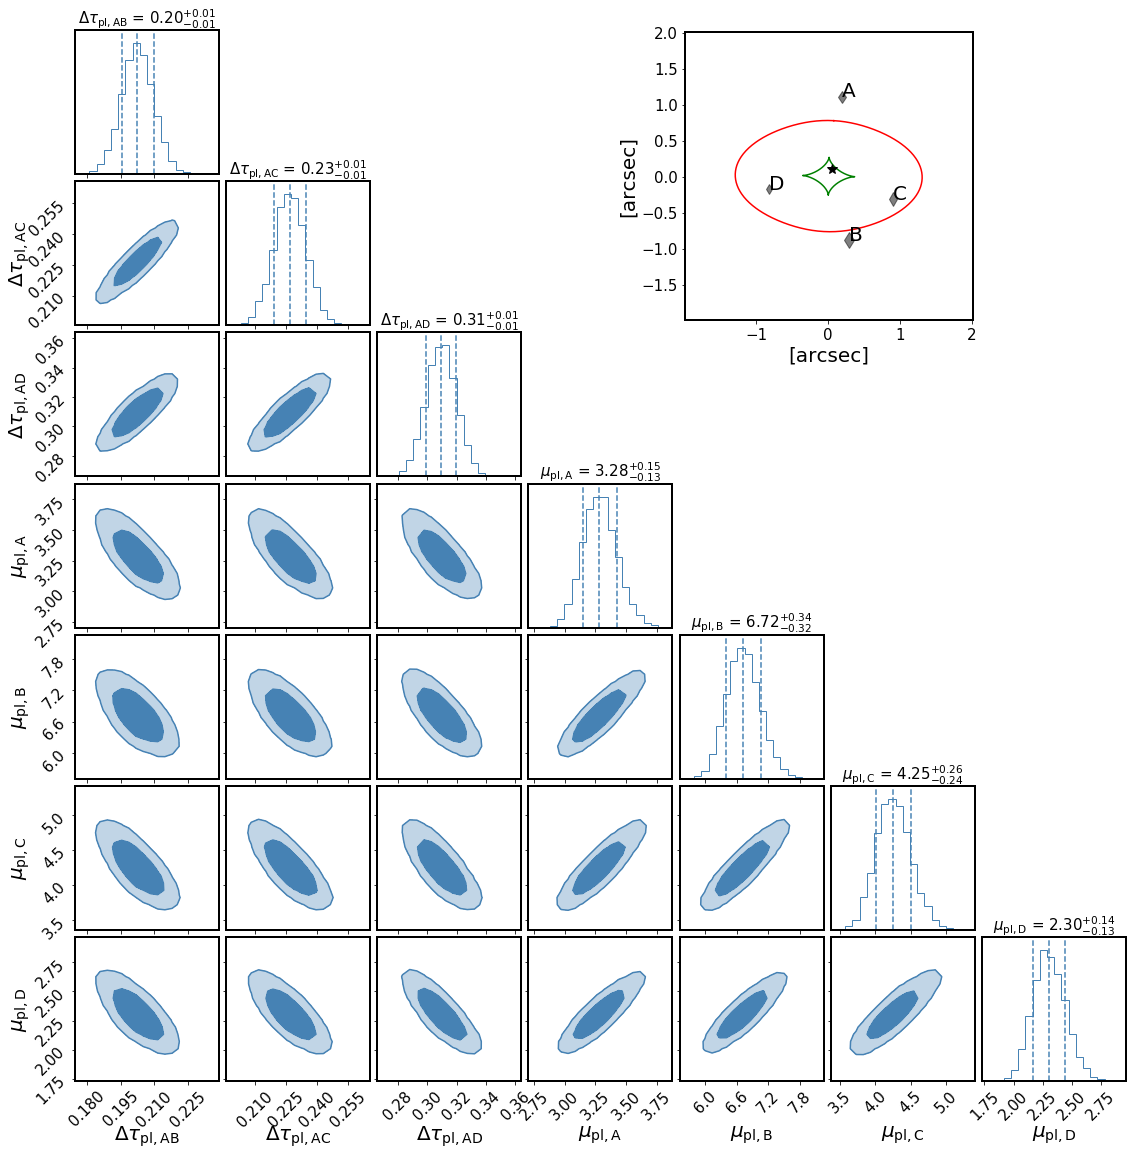

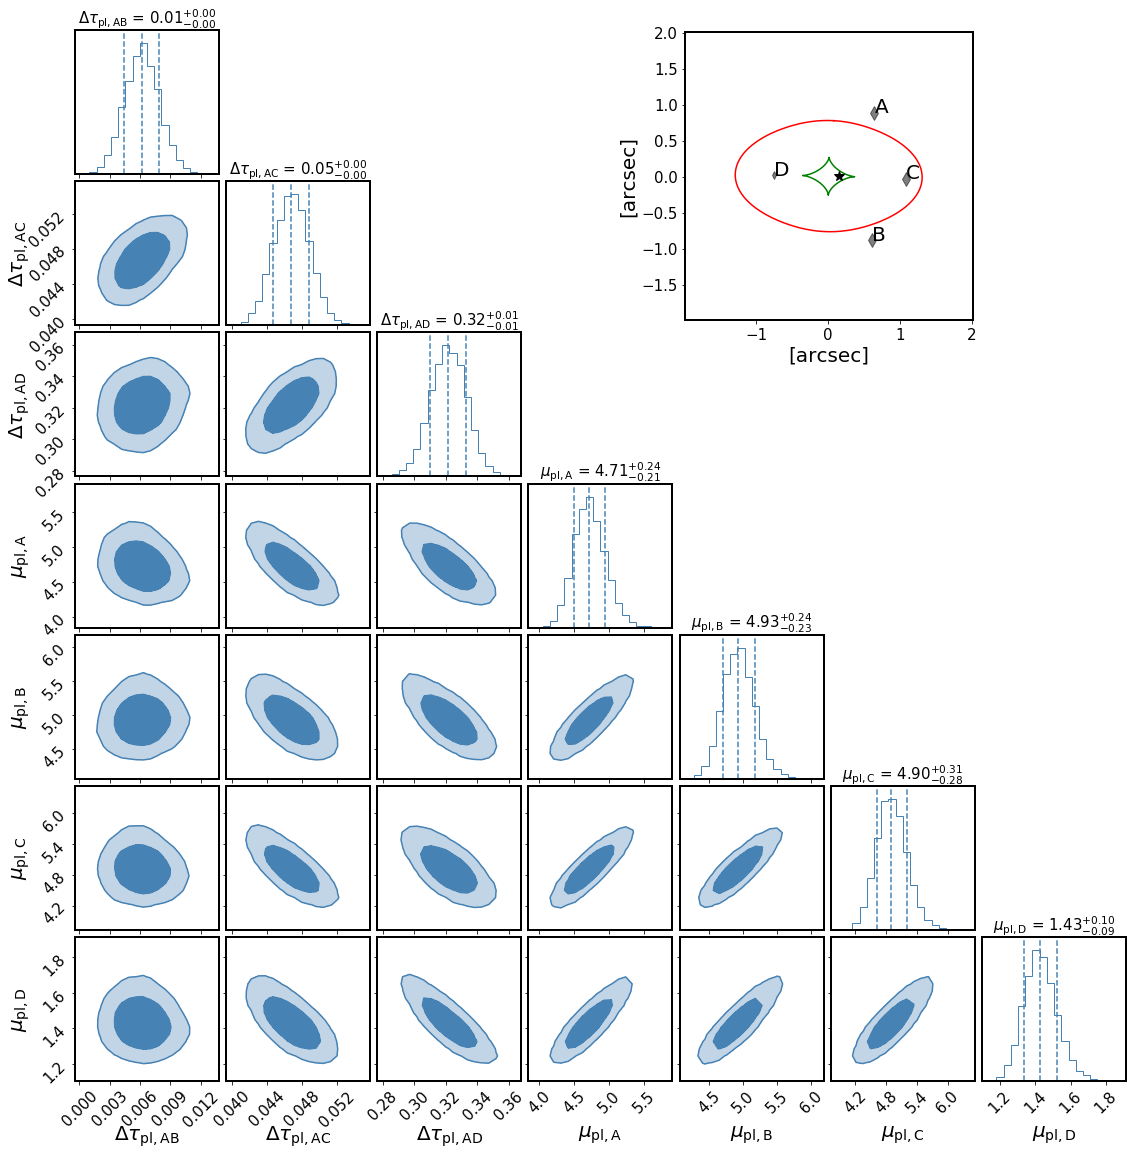

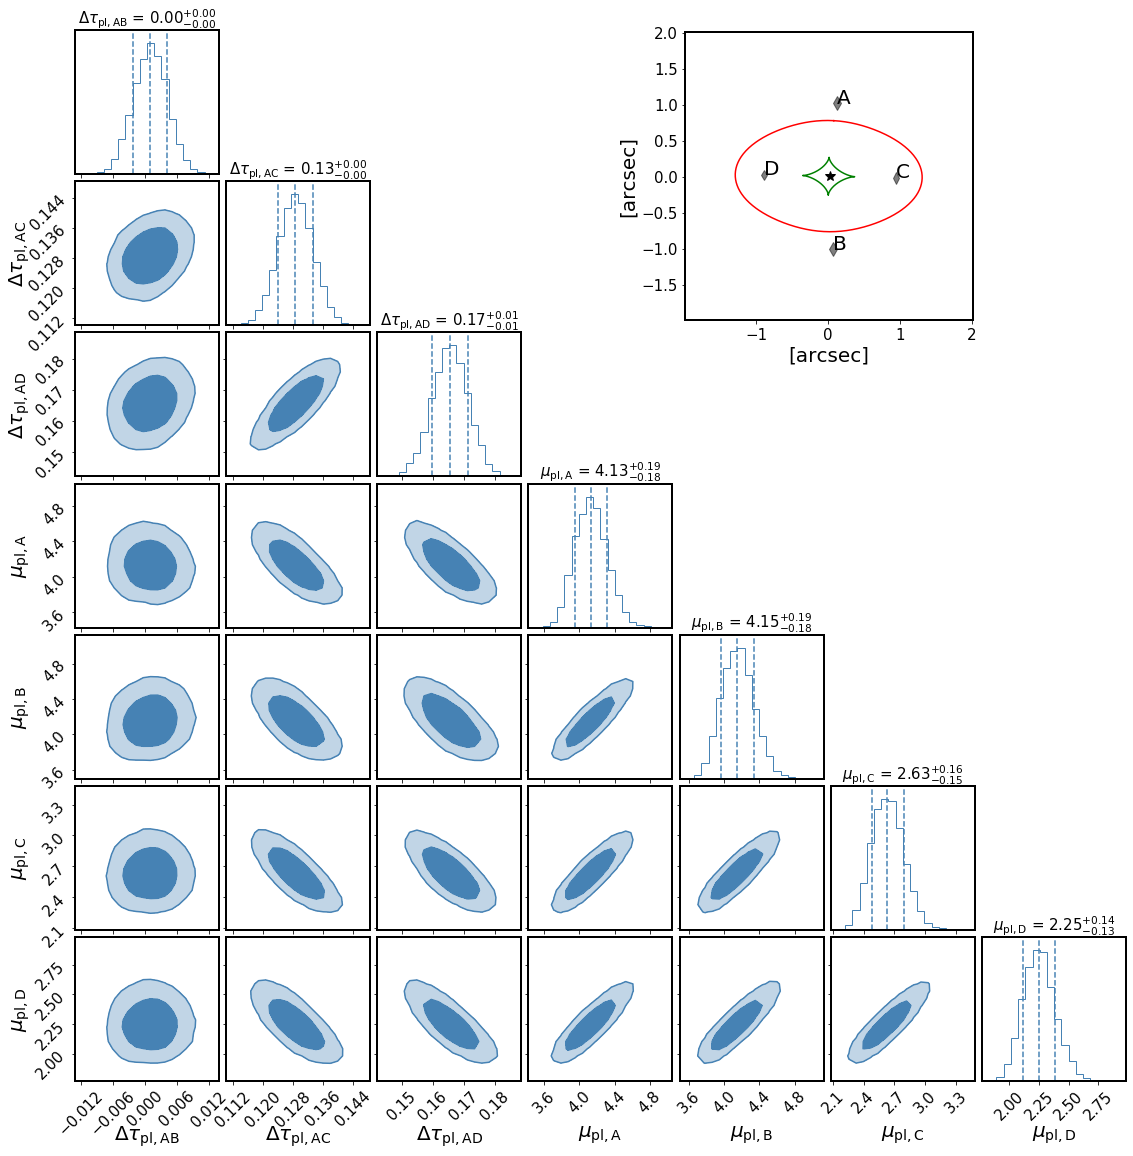

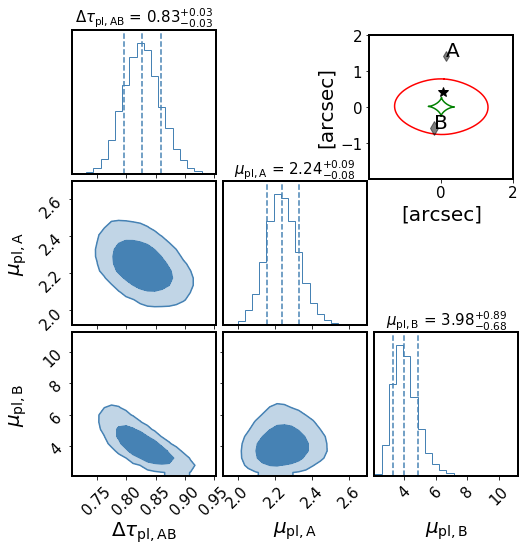

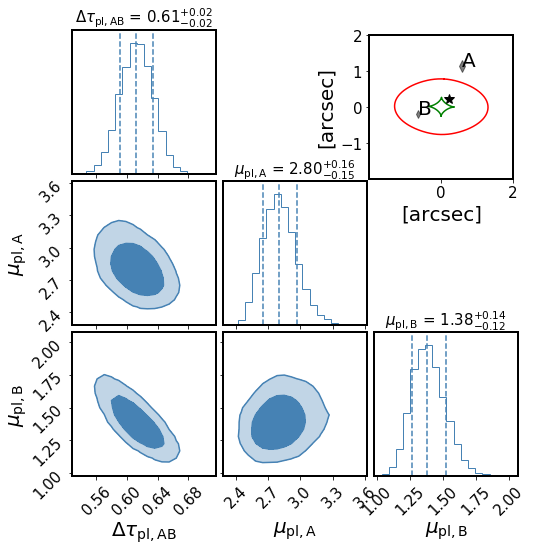

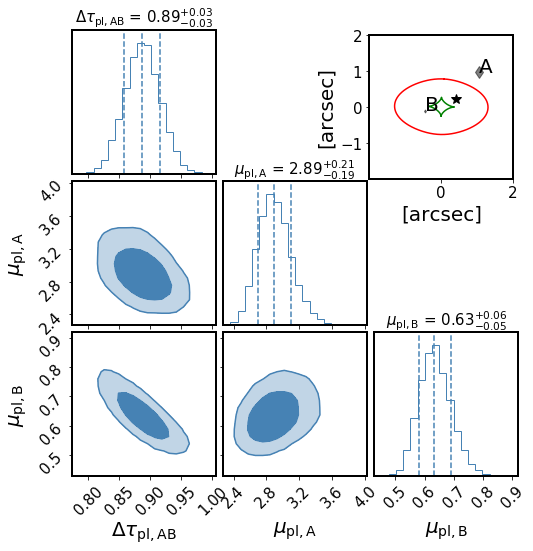

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

save_plot = False  # (only option for paper writing)

# matplotlib configs
from pylab import rc
rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)
rc('text', usetex=False)

def plot_lens(mcmc_chain, kwargs_ps):
    """
    plotting posteriors with the lens model configuration
    """

    alpha = 0.8
    num_param = len(mcmc_chain[0, :])
    if num_param == 7:
        labels = [r"$\Delta\tau_{\rm pl, AB}$", r"$\Delta\tau_{\rm pl, AC}$", r"$\Delta\tau_{\rm pl, AD}$", r"$\mu_{\rm pl, A}$", r"$\mu_{\rm pl, B}$", r"$\mu_{\rm pl, C}$", r"$\mu_{\rm pl, D}$"]
    elif num_param == 3:
        labels = [r"$\Delta\tau_{\rm pl, AB}$", r"$\mu_{\rm pl, A}$", r"$\mu_{\rm pl, B}$"]
    else:
        raise ValueError('number of parameters does not match a quad or double posterior sample')
        
    kwargs_corner = {'bins': 20, 'plot_datapoints': False, 'show_titles': True, 'title_kwargs': dict(fontsize=15),
                     'label_kwargs': dict(fontsize=20), 'smooth': 0.7, 'levels': [0.68,0.95],
                    'fill_contours': True, 'alpha': alpha}

    fig = corner.corner(mcmc_chain, labels=labels,
                        quantiles=[0.16, 0.5, 0.84],
                        color='steelblue', **kwargs_corner)

    
    if num_param == 7:
        parent_axes = fig.axes[11]
        inset_ax = inset_axes(parent_axes, width=4, height=4., loc=3)
    elif num_param == 3:
        parent_axes = fig.axes[2]
        inset_ax = inset_axes(parent_axes, width=2, height=2., loc=1)

    lens_plot.lens_model_plot(inset_ax, lens_model, kwargs_lens_pl_true, 
                              sourcePos_x=kwargs_ps[0]['ra_source'], sourcePos_y=kwargs_ps[0]['dec_source'], **kwargs_lens_plot)
    inset_ax.set_xlabel('[arcsec]', fontsize=20)
    inset_ax.set_ylabel('[arcsec]', fontsize=20)
    return fig


    
fig = plot_lens(mcmc_chain_fold, kwargs_ps_fold)
if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/fold_image_posteriors.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
fig.show()
fig = plot_lens(mcmc_chain_cusp, kwargs_ps_cusp)
if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/cusp_image_posteriors.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
fig.show()
fig = plot_lens(mcmc_chain_cross, kwargs_ps_cross)
if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/cross_image_posteriors.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
fig.show()

fig = plot_lens(mcmc_chain_double1, kwargs_ps_double1)
if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/double1_image_posteriors.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
fig.show()

fig = plot_lens(mcmc_chain_double2, kwargs_ps_double2)
if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/double2_image_posteriors.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
fig.show()

fig = plot_lens(mcmc_chain_double3, kwargs_ps_double3)
if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/double3_image_posteriors.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
fig.show()

In [14]:
# ================================================================
# compute absolute uncertainty error budget of the macro-model fit
# ================================================================


def mu_macro_uncertainty(mcmc_chain):
    """
    estimates the uncertainty budget of the smooth lens model (without MST) prediction of the glSNe magnifications
    We estimate the error from all 4 images combined with their relative uncertainties.
    """
    mu_mean_list = np.zeros(4)
    mu_std_list = np.zeros(4)
    k = 0
    for i in range(3, 7):
        mu = mcmc_chain[:, i]
        mu_mean_list[k] = np.mean(mu)
        mu_std_list[k] = np.std(mu)
        k += 1
    rel_error_tot = 1/ np.sqrt(np.sum((mu_mean_list/mu_std_list)**2))
    return rel_error_tot


def fermat_macro_uncertainty(mcmc_chain):
    """
    estimates the uncertainty budget of the smooth lens model (without MST) prediction of the glSNe Fermat potential differences.
    We estimate the error from all 3 relative images combined with their relative uncertainties.
    """
    tau_mean_list = np.zeros(3)
    tau_std_list = np.zeros(3)
    k = 0
    for i in range(0, 3):
        tau = mcmc_chain[:, i]
        tau_mean_list[k] = np.mean(tau)
        tau_std_list[k] = np.std(tau)
        k += 1
    rel_error_tot = 1/ np.sqrt(np.sum((tau_mean_list/tau_std_list)**2))
    return rel_error_tot

rel_error = mu_macro_uncertainty(mcmc_chain_cusp)
print(rel_error * np.sqrt(4), 'cusp magnifications')

rel_error = mu_macro_uncertainty(mcmc_chain_cross)
print(rel_error * np.sqrt(4), 'cross magnifications')

rel_error = mu_macro_uncertainty(mcmc_chain_fold)
print(rel_error * np.sqrt(4), 'fold magnifications')

print('==================')
rel_error = fermat_macro_uncertainty(mcmc_chain_cusp)
print(rel_error * np.sqrt(3), 'cusp Fermat potential')

rel_error = fermat_macro_uncertainty(mcmc_chain_cross)
print(rel_error * np.sqrt(3), 'cross Fermat potential')

rel_error = fermat_macro_uncertainty(mcmc_chain_fold)
print(rel_error * np.sqrt(3), 'fold Fermat potential')


0.054503291884276724 cusp magnifications
0.05056608483634541 cross magnifications
0.0514500673771108 fold magnifications
0.04776540742004857 cusp Fermat potential
0.04349455904607589 cross Fermat potential
0.03448757721426094 fold Fermat potential


## glSNe scenario

In this section, we define the number, redshift range and uncertainties in different measurements for our forecast.

In [15]:
# ===============
# Number of glSNe
# ===============

num_sne_cusp = 11  # number of cusp lensed SNe
num_sne_cross = 11  # number of cross lensed SNe
num_sne_fold = 11  # number of fold lensed SNe
num_sne_double1 = 40  # number of double #1 lensed SNe
num_sne_double2 = 40  # number of double #2 lensed SNe
num_sne_double3 = 40  # number of double #3 lensed SNe
 
# ===========================================
# Redshift distribution of lenses and sources
# ===========================================


def draw_redshift():
    """
    distribution of lens and source redshift to be drawn from.
    """
    # approximately matching Suyu et al. 2020
    z_lens = np.random.uniform(low=0.1, high=0.5)  # deflector redshift
    z_source = np.random.uniform(low=z_lens+0.2, high=1.0)  # source redshift
    return z_lens, z_source


# ==================================
# Time-delay measurement uncertainty
# ==================================

time_delay_precision = 2.  # precision in time-delay measurement from SNe in units of days (1-sigma)
# we assume independent relative time-delay measurements in the reference frame of the given images AB, AC, AD (this is an approximation)




In [16]:

# routines to draw a population with the uncertainties provided, and to configure the the likelihood for hierArc



def draw_true_lens_sne(kwargs_lens, kwargs_ps):
    """
    compute observables for the given lens model with the source-lens redshift configuration drawn from a distribution
    """
    # compute image positions, time delays and magnifications
    z_lens, z_source = draw_redshift()
    lens_cosmo = LensCosmo(z_lens, z_source, cosmo_true)
    magnitude_source = draw_mag_source(z_source)
    lambda_mst = draw_lambda_tot_true()
    
    lensModel = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo_true)
    psModel = PointSource(point_source_type_list=point_source_model, lensModel=lensModel)

    x_pos, y_pos = psModel.image_position(kwargs_ps, kwargs_lens)
    x_image, y_image = x_pos[0], y_pos[0]  # only chose the first point source model (includes all images)
    magnification_model = lensModel.magnification(x_image, y_image, kwargs_lens)
    magnification_model = np.abs(magnification_model)
    magnitude_image = magnitude_source - 2.5 * np.log10(magnification_model / lambda_mst**2)
    arrival_time = lensModel.arrival_time(x_image, y_image, kwargs_lens, kappa_ext=0) * lambda_mst
    fermat_pot_pl = lensModel.fermat_potential(x_image, y_image, kwargs_lens)# * lambda_mst
    fermat_pot_pl_diff = fermat_pot_pl[1:] - fermat_pot_pl[0]
    time_delay_diff = arrival_time[1:] - arrival_time[0]
    # print(time_delay_diff, 'time delay difference')
    return magnitude_image, magnification_model, time_delay_diff, fermat_pot_pl_diff, x_image, y_image, z_lens, z_source, lambda_mst


def draw_lens_measured(magnitude_image, time_delay, x_image, y_image, mag_eff_rms_std, mag_eff_rms_ml):
    """
    add measurement errors and return a realization of the measurement with the covariance matrices
    """

    #cov_td_measured = np.ones((len(time_delay), len(time_delay))) * time_delay_precision**2  # fully covariant time delay measurement uncertainties
    cov_td_measured = np.diag(np.ones(len(time_delay)) * time_delay_precision**2)
    mag_eff_rms = np.zeros_like(magnitude_image)
    mag_eff_rms[0] = mag_eff_rms_std
    mag_eff_rms[1:] = mag_eff_rms_ml
    cov_magnitude_measured = np.diag((mag_eff_rms)**2)
    time_delay_measured = np.random.multivariate_normal(time_delay, cov_td_measured)
    magnitude_measured = np.random.multivariate_normal(magnitude_image, cov_magnitude_measured)
    x_image_measured = np.random.normal(x_image, astrometric_precision)
    y_image_measured = np.random.normal(y_image, astrometric_precision)
    return time_delay_measured, cov_td_measured, magnitude_measured, cov_magnitude_measured, x_image_measured, y_image_measured
    

def draw_lens_likelihood(lens_config, mag_eff_rms_std, mag_eff_rms_ml):
    """
    draw a mock lens, perform the modeling inference and assemple all the likelihood pieces
    """
    if lens_config == 'cusp':
        cov_model = cov_model_cusp
        kwargs_ps = kwargs_ps_cusp
    elif lens_config == 'cross':
        cov_model = cov_model_cross
        kwargs_ps = kwargs_ps_cross
    elif lens_config == 'fold':
        cov_model = cov_model_fold
        kwargs_ps = kwargs_ps_fold
    elif lens_config == 'double1':
        cov_model = cov_model_double1
        kwargs_ps = kwargs_ps_double1
    elif lens_config == 'double2':
        cov_model = cov_model_double2
        kwargs_ps = kwargs_ps_double2
    elif lens_config == 'double3':
        cov_model = cov_model_double3
        kwargs_ps = kwargs_ps_double3
    else:
        raise ValueError('lens_config %s not supported!' % lens_config)
    magnitude_image, magnification_model, time_delay_diff, fermat_pot_pl_diff, x_image, y_image, z_lens, z_source, lambda_int_i = draw_true_lens_sne(kwargs_lens_pl_true, kwargs_ps)
    time_delay_measured, cov_td_measured, magnitude_measured, cov_magnitude_measured, x_image_measured, y_image_measured = draw_lens_measured(magnitude_image, time_delay_diff, x_image, y_image, mag_eff_rms_std, mag_eff_rms_ml)

    model_true = np.append(fermat_pot_pl_diff, -2.5*np.log10(magnification_model))
    model_mean = np.random.multivariate_normal(model_true, cov_model)
    n = len(x_image)
    fermat_diff = model_mean[:n]
    mag = model_mean[n:]

    kwargs_likelihood = {'z_lens': z_lens, 
                         'z_source': z_source, 
                         'likelihood_type': 'TDMagMagnitude',
                         'time_delay_measured': time_delay_measured, 
                         'cov_td_measured': cov_td_measured,
                         'fermat_diff': fermat_diff,
                         'magnitude_measured': magnitude_measured, 
                         'cov_magnitude_measured': cov_magnitude_measured,
                         'magnification_model': mag,
                         'cov_model': cov_model,
                         'num_distribution_draws': 100}
    return kwargs_likelihood


def generate_sample_likelihood(mag_eff_rms_std, mag_eff_rms_ml):
    """
    generates the sample likelihood object for hierArc given all the specifications in the notebook
    flux_eff_rms: float, relative uncertainty in the supernovae magnification 
    comming from the flux measurement (uncertainty in peak brightness) and unresolved lensing effects (mili- and micro-lensing)
    """
    kwargs_likelihood_list = []
    for i in range(num_sne_cusp):
        kwargs_likelihood_list.append(draw_lens_likelihood(lens_config='cusp', mag_eff_rms_std=mag_eff_rms_std, mag_eff_rms_ml=mag_eff_rms_ml))
    for i in range(num_sne_cross):
        kwargs_likelihood_list.append(draw_lens_likelihood(lens_config='cross', mag_eff_rms_std=mag_eff_rms_std, mag_eff_rms_ml=mag_eff_rms_ml))
    for i in range(num_sne_fold):
        kwargs_likelihood_list.append(draw_lens_likelihood(lens_config='fold', mag_eff_rms_std=mag_eff_rms_std, mag_eff_rms_ml=mag_eff_rms_ml))
    for i in range(num_sne_double1):
        kwargs_likelihood_list.append(draw_lens_likelihood(lens_config='double1', mag_eff_rms_std=mag_eff_rms_std, mag_eff_rms_ml=mag_eff_rms_ml))
    for i in range(num_sne_double2):
        kwargs_likelihood_list.append(draw_lens_likelihood(lens_config='double2', mag_eff_rms_std=mag_eff_rms_std, mag_eff_rms_ml=mag_eff_rms_ml))
    for i in range(num_sne_double3):
        kwargs_likelihood_list.append(draw_lens_likelihood(lens_config='double3', mag_eff_rms_std=mag_eff_rms_std, mag_eff_rms_ml=mag_eff_rms_ml))
    return kwargs_likelihood_list


In [34]:
# ==============================================
# generate likelihood configurations for hierArc
# ==============================================

np.random.seed(42)
re_generate_sample = False

file_likelihood_00 = os.path.join(path2posteriors, 'likelihood_00_mag.pkl')
file_likelihood_02 = os.path.join(path2posteriors, 'likelihood_02_mag.pkl')
file_likelihood_10 = os.path.join(path2posteriors, 'likelihood_10_mag.pkl')

mag_eff_rms_ml = 1.0

if re_generate_sample:
    kwargs_likelihood_list_00 = generate_sample_likelihood(mag_eff_rms_std=0, mag_eff_rms_ml=mag_eff_rms_ml)
    kwargs_likelihood_list_02 = generate_sample_likelihood(mag_eff_rms_std=0.2, mag_eff_rms_ml=mag_eff_rms_ml)
    kwargs_likelihood_list_10 = generate_sample_likelihood(mag_eff_rms_std=1., mag_eff_rms_ml=mag_eff_rms_ml)

    
    dbfile = open(file_likelihood_00, 'wb')
    pickle.dump(kwargs_likelihood_list_00, dbfile)                     
    dbfile.close()
    
    dbfile = open(file_likelihood_02, 'wb')
    pickle.dump(kwargs_likelihood_list_02, dbfile)                     
    dbfile.close()
    
    dbfile = open(file_likelihood_10, 'wb')
    pickle.dump(kwargs_likelihood_list_10, dbfile)                     
    dbfile.close()
    
else:
    dbfile = open(file_likelihood_00, 'rb')     
    kwargs_likelihood_list_00 = pickle.load(dbfile)
    dbfile.close()
    
    dbfile = open(file_likelihood_02, 'rb')     
    kwargs_likelihood_list_02 = pickle.load(dbfile)
    dbfile.close()
    
    dbfile = open(file_likelihood_10, 'rb')     
    kwargs_likelihood_list_10 = pickle.load(dbfile)
    dbfile.close()

    

In [35]:
# illustrate
z_d_double, z_d_quad = [], []
z_s_double, z_s_quad = [], []
dt_max_doube, dt_max_quad = [], []
double_list, quad_list = [], []
magnitude_min_double, magnitude_max_double = [], []
magnitude_min_quad, magnitude_max_quad = [], []

for kwargs_likelihood in kwargs_likelihood_list_00:
    dt = kwargs_likelihood['time_delay_measured']
    mag = kwargs_likelihood['magnitude_measured']
    dt_max = np.max(dt)
    mag_min = np.min(mag)
    mag_max = np.max(mag)
    z_d = kwargs_likelihood['z_lens']
    z_s = kwargs_likelihood['z_source']
    if len(dt) == 1:
        z_d_double.append(z_d)
        z_s_double.append(z_s)
        dt_max_doube.append(dt_max)
        magnitude_min_double.append(mag_min)
        magnitude_max_double.append(mag_max)
        double_list.append([z_d, z_s, dt_max, mag_min, mag_max])
    else:
        z_d_quad.append(z_d)
        z_s_quad.append(z_s)
        dt_max_quad.append(dt_max)
        magnitude_min_quad.append(mag_min)
        magnitude_max_quad.append(mag_max)
        quad_list.append([z_d, z_s, dt_max, mag_min, mag_max])
        
quad_list = np.array(quad_list)
double_list = np.array(double_list)


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


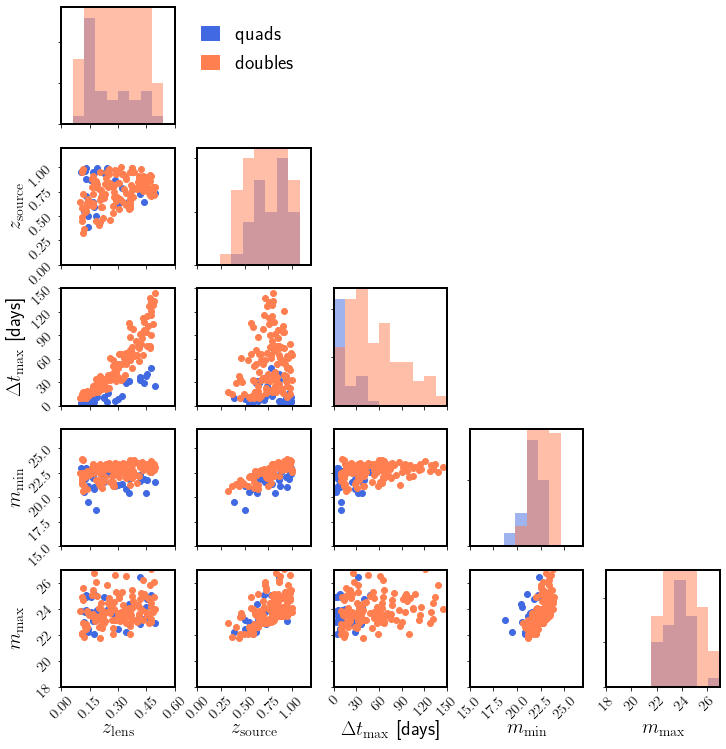

In [36]:
# myplots is a derivative of the corner library that I host on my github repo: https://github.com/sibirrer/myplots
from myplots import triangle
color_list = ['royalblue', 'coral', 'rebeccapurple']

labels = [r"$z_{\rm lens}$", r"$z_{\rm source}$", r"$\Delta t_{\rm max}$ [days]", r"$m_{\rm min}$", r"$m_{\rm max}$"] 
extents = [[0, 0.6], [0, 1.2], [0, 150], [15, 27], [18, 27]]



fig, axes = triangle.corner_multi(xs_list=[quad_list, double_list], 
                      weights_list=None, labels=labels, fontsize=20, show_titles=False, title_fmt=".2f",
           title_args={}, extents=extents, truths=None, truth_color="#4682b4",
           scale_hist=False, quantiles=[], verbose=False, dots=None, hist1d_bool=True,
                 scatter_plot=True, kwargs_scatter={'marker': 'o', 'linestyle': ''},
                 cmap_list=["Blues", "Greens", "Oranges", "Reds", "BuPu", "binary"],
                 line_style_list = ['solid', 'solid', 'solid'],
                 color_list=color_list,
                 kwargs_hist2d={}, kwargs_hist1d={'linewidth': 3, 'density': False, 'histtype': "bar", 'alpha': 0.5, 'bins': 10})


ax = axes[0,1]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


patch_1 = mpatches.Patch(color=color_list[0], label='quads')
patch_2 = mpatches.Patch(color=color_list[1], label='doubles')

ax.legend(handles=[patch_1, patch_2], fontsize=20, handlelength=0.9, loc=1, frameon=False)
fig.subplots_adjust(left  = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.2)

#plt.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/sample_selection.pdf')
fig.show()


## hierArc sampling settings
Here we specify the sampling settings for the inferences performed with hierArc

In [37]:

# =============================
# EMCEE SAMPLING CONFIGURATIONS
# =============================

# file name of chains. ATTENTION!!! Do not store them in version control and chose a different path!

# Set up the backend
# Don't forget to clear it in case the file already exists
# backend_sne = emcee.backends.HDFBackend(filename_sne)
   
# these configs are such that you can locally execute it in few hours, not meant to provide converged chains!
kwargs_emcee_glSNe = {'n_walkers': 50,  # number of walkers
                'n_run': 200,  # number of iterations saved in the file
                'n_burn': 200,  # number of iterations as burn-in prior to start saving the chain
                'pool': None,  # (option) emcee pool for multi-threading or MPI, see e.g. emcee documentation or usage in lenstronomy
                'continue_from_backend': True,  # boolean, if True, continues sampling the emcee chain from a backend (if exists), otherwise deletes previous chains and starts from scratch
                'kwargs_mean_start': kwargs_mean_start,  # starting positions as configured
                'kwargs_sigma_start': kwargs_sigma_start,  # starting position as configured
                #'backend': backend_sne,
               }



kwargs_bounds_sne_sl = {'kwargs_lower_cosmo': kwargs_lower_cosmo,
                     'kwargs_upper_cosmo': kwargs_upper_cosmo,
                     'kwargs_fixed_cosmo': {},  
                     'kwargs_lower_source': kwargs_lower_source,
                     'kwargs_upper_source': kwargs_upper_source,
                     'kwargs_fixed_source': {'sigma_sne': sigma_sne_true}, 
                     'kwargs_lower_lens': kwargs_lower_lens,
                     'kwargs_upper_lens': kwargs_upper_lens,
                     'kwargs_fixed_lens': {'lambda_mst_sigma': lambda_int_true_sigma,
                                           'kappa_ext': kappa_ext_mean_true, 
                                           'kappa_ext_sigma': kappa_ext_sigma_true}, 
                }


# ==================================
# joint options for hierArc sampling
# ==================================

kwargs_sampler_glSNe_mock = {'cosmology': cosmology, 'kwargs_bounds': kwargs_bounds_sne_sl,
                  'lambda_mst_sampling': True, 'lambda_mst_distribution': lambda_int_distribution, 
                  'kappa_ext_sampling': True, 'kappa_ext_distribution': kappa_ext_distribution, 
                  'alpha_lambda_sampling': False, 
                  #'sne_likelihood': 'Pantheon', # we are using the Pantheon sample as the likelihood
                  'sne_likelihood': 'CUSTOM',
                  'kwargs_sne_likelihood': kwargs_sne_likelihood_mock,
                  'sne_apparent_m_sampling': True, 
                  'sne_distribution': 'GAUSSIAN',
                  'z_apparent_m_anchor': z_apparent_m_anchor,
                  'log_scatter': False,
                  'interpolate_cosmo': True, 'num_redshift_interp': 100}

kwargs_sampler_glSNe_roman = {'cosmology': cosmology, 'kwargs_bounds': kwargs_bounds_sne_sl,
                  'lambda_mst_sampling': True, 'lambda_mst_distribution': lambda_int_distribution, 
                  'kappa_ext_sampling': True, 'kappa_ext_distribution': kappa_ext_distribution, 
                  'alpha_lambda_sampling': False, 
                  #'sne_likelihood': 'Pantheon', # we are using the Pantheon sample as the likelihood
                  'sne_likelihood': 'CUSTOM',
                  'kwargs_sne_likelihood': kwargs_sne_likelihood_roman,
                  'sne_apparent_m_sampling': True, 
                  'sne_distribution': 'GAUSSIAN',
                  'z_apparent_m_anchor': z_apparent_m_anchor,
                  'log_scatter': False,
                  'interpolate_cosmo': True, 'num_redshift_interp': 100}


kwargs_sampler_glSNe_pantheon = {'cosmology': cosmology, 'kwargs_bounds': kwargs_bounds_sne_sl,
                  'lambda_mst_sampling': True, 'lambda_mst_distribution': lambda_int_distribution, 
                  'kappa_ext_sampling': True, 'kappa_ext_distribution': kappa_ext_distribution, 
                  'alpha_lambda_sampling': False, 
                  'sne_likelihood': 'Pantheon', # we are using the Pantheon sample as the likelihood
                  #'sne_likelihood': 'CUSTOM',
                  #'kwargs_sne_likelihood': kwargs_sne_likelihood_mock,
                  'sne_apparent_m_sampling': True, 
                  'sne_distribution': 'GAUSSIAN',
                  'z_apparent_m_anchor': z_apparent_m_anchor,
                  'log_scatter': False,
                  'interpolate_cosmo': True, 'num_redshift_interp': 100}


# ==============
# fix lambda_int
# ==============

kwargs_bounds_sne_sl_fix_mst = {'kwargs_lower_cosmo': kwargs_lower_cosmo,
                     'kwargs_upper_cosmo': kwargs_upper_cosmo,
                     'kwargs_fixed_cosmo': {},  
                     'kwargs_lower_source': kwargs_lower_source,
                     'kwargs_upper_source': kwargs_upper_source,
                     'kwargs_fixed_source': {'sigma_sne': sigma_sne_true}, 
                     'kwargs_lower_lens': kwargs_lower_lens,
                     'kwargs_upper_lens': kwargs_upper_lens,
                     'kwargs_fixed_lens': kwargs_lens_true, 
                }


kwargs_sampler_glSNe_fix_mst = {'cosmology': cosmology, 'kwargs_bounds': kwargs_bounds_sne_sl_fix_mst,
                  'lambda_mst_sampling': True, 'lambda_mst_distribution': lambda_int_distribution, 
                  'kappa_ext_sampling': True, 'kappa_ext_distribution': kappa_ext_distribution, 
                  'alpha_lambda_sampling': False, 
                  'sne_likelihood': 'Pantheon', # we are using the Pantheon sample as the likelihood
                  #'sne_likelihood': 'CUSTOM',
                  #'kwargs_sne_likelihood': kwargs_sne_likelihood_mock,
                  'sne_apparent_m_sampling': True, 
                  'sne_distribution': 'GAUSSIAN',
                  'z_apparent_m_anchor': z_apparent_m_anchor,
                  'log_scatter': False,
                  'interpolate_cosmo': True, 'num_redshift_interp': 100}


kwargs_sampler_glSNe_fix_mst_roman = {'cosmology': cosmology, 'kwargs_bounds': kwargs_bounds_sne_sl_fix_mst,
                  'lambda_mst_sampling': True, 'lambda_mst_distribution': lambda_int_distribution, 
                  'kappa_ext_sampling': True, 'kappa_ext_distribution': kappa_ext_distribution, 
                  'alpha_lambda_sampling': False,
                  'sne_likelihood': 'CUSTOM',
                  'kwargs_sne_likelihood': kwargs_sne_likelihood_roman,
                  'sne_apparent_m_sampling': True, 
                  'sne_distribution': 'GAUSSIAN',
                  'z_apparent_m_anchor': z_apparent_m_anchor,
                  'log_scatter': False,
                  'interpolate_cosmo': True, 'num_redshift_interp': 100}



# Run forcasts


In [38]:
# ==================================================
# keeping the MST components fixed at the true value
# ==================================================

re_compute_mst_fixed = False

backend_fix_mst = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_fix_mst_mag.h5'))
backend_fix_mst_roman = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_fix_mst_roman_mag.h5'))
lable_glSNe_fix_mst = r' \textsc{Pantheon\_no\_mst}'
lable_glSNe_fix_mst_roman = r' \textsc{Roman\_no\_mst}'



if re_compute_mst_fixed == True:
    mcmc_sampler_glSNe_fix_mst = MCMCSampler(kwargs_likelihood_list=kwargs_likelihood_list_10, **kwargs_sampler_glSNe_fix_mst)
    mcmc_samples_glSNe_fix_mst, log_prob_glSNe_fix_mst = mcmc_sampler_glSNe_fix_mst.mcmc_emcee(backend=backend_fix_mst, **kwargs_emcee_glSNe)

    mcmc_sampler_glSNe_fix_mst_roman = MCMCSampler(kwargs_likelihood_list=kwargs_likelihood_list_10, **kwargs_sampler_glSNe_fix_mst_roman)
    mcmc_samples_glSNe_fix_mst_roman, log_prob_glSNe_fix_mst_roman = mcmc_sampler_glSNe_fix_mst_roman.mcmc_emcee(backend=backend_fix_mst_roman, **kwargs_emcee_glSNe)

else:
    n_burn = kwargs_emcee_glSNe['n_burn']
    mcmc_samples_glSNe_fix_mst = backend_fix_mst.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_glSNe_fix_mst = backend_fix_mst.get_log_prob(discard=n_burn, flat=True, thin=1)
    
    mcmc_samples_glSNe_fix_mst_roman = backend_fix_mst_roman.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_glSNe_fix_mst_roman = backend_fix_mst_roman.get_log_prob(discard=n_burn, flat=True, thin=1)



/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/corner/core.py:660: UserWarning: The following kwargs were not used by contour: 'color'
  **contourf_kwargs,
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


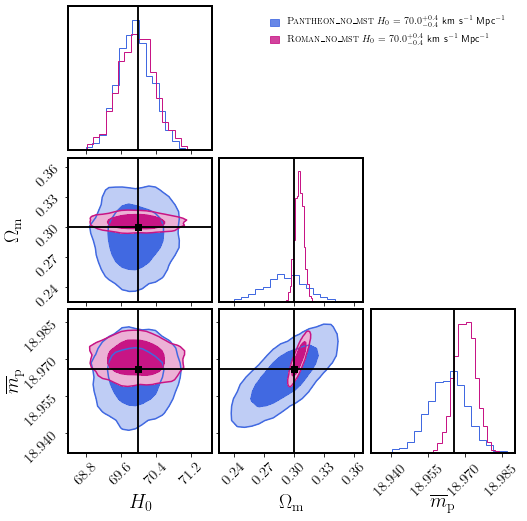

In [39]:
save_plot = False

rc('text', usetex=True)


mcmc_sampler_glSNe_fix_mst = MCMCSampler(kwargs_likelihood_list=kwargs_likelihood_list_00, **kwargs_sampler_glSNe_fix_mst)
truths = mcmc_sampler_glSNe_fix_mst.param.kwargs2args(kwargs_cosmo=kwargs_cosmo_true, kwargs_lens=kwargs_lens_true, kwargs_source=kwargs_source_true)

color_list = ['royalblue', 'coral', 'mediumvioletred', 'rebeccapurple', 'steelblue', 'crimson', 'g', 'purple', 'orange', 'r', 'k']
levels = [0.68,0.95]
alpha = 0.8
#extents = [[60, 80], [0.2, 0.4], [0.8, 1.2], [0, 0.1], [mu_sne_true-0.05, mu_sne_true+0.05]]

kwargs_corner = {'bins': 20, 'alpha': 0.2, 'smooth': 0.9, 'smooth1d': None, 
                 'levels': levels, 'truths': truths, 'truth_color': 'k',
                 'fill_contours': True, 'plot_datapoints': False,}
                 #'range': extents}


fig = corner.corner(mcmc_samples_glSNe_fix_mst, labels=mcmc_sampler_glSNe_fix_mst.param_names(latex_style=True),
                    color=color_list[0],
                    #range=extents,
                    #show_titles=True,
                    hist_kwargs= {'density': True, 'color': color_list[0]},
                    #title_kwargs=dict(fontsize=15),
                    label_kwargs=dict(fontsize=20),
                    contourf_kwargs={'color': color_list[0]},
                    **kwargs_corner)

fig = corner.corner(mcmc_samples_glSNe_fix_mst_roman, color=color_list[2], fig=fig,
                    hist_kwargs= {'density': True, 'color': color_list[2]}, **kwargs_corner)


ax = fig.axes[2]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

result_string_ = plot_util.result_string(mcmc_samples_glSNe_fix_mst[:, 0]/np.median(mcmc_samples_glSNe_fix_mst[:, 0])*70.0, weights=None, title_fmt=".1f", label=r'$H_0$')
patch_1 = mpatches.Patch(color=color_list[0], label=lable_glSNe_fix_mst + '  ' + result_string_ +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)

result_string_ = plot_util.result_string(mcmc_samples_glSNe_fix_mst_roman[:, 0]/np.median(mcmc_samples_glSNe_fix_mst_roman[:, 0])*70.0, weights=None, title_fmt=".1f", label=r'$H_0$')
patch_2 = mpatches.Patch(color=color_list[2], label=lable_glSNe_fix_mst_roman + '  ' + result_string_ +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)




ax.legend(handles=[patch_1, patch_2], fontsize=10, handlelength=0.9, loc=1, frameon=False)

if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/fix_mst_pantheon_vs_roman_sne.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

fig.show()

In [40]:

re_compute_glSNe_pantheon = False
re_compute_glSNe_roman = False

lable_glSNe_pantheon_00 = r' \textsc{Pantheon\_ideal}'
lable_glSNe_pantheon_02 = r' \textsc{Pantheon\_realistic}'
lable_glSNe_pantheon_10 = r' \textsc{Pantheon\_extreme}'


lable_glSNe_roman_00 = r' \textsc{Roman\_ideal}'
lable_glSNe_roman_02 = r' \textsc{Roman\_realistic}'
lable_glSNe_roman_10 = r' \textsc{Roman\_extreme}'


if re_compute_glSNe_pantheon == True:
    # Pantheon SNe sample
    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_pantheon_00_mag.h5'))
    mcmc_sampler_glSNe_pantheon_00 = MCMCSampler(kwargs_likelihood_list=kwargs_likelihood_list_00, **kwargs_sampler_glSNe_pantheon)
    mcmc_samples_glSNe_pantheon_00, log_prob_glSNe_pantheon_00 = mcmc_sampler_glSNe_pantheon_00.mcmc_emcee(backend=backend, **kwargs_emcee_glSNe)

    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_pantheon_02_mag.h5'))
    mcmc_sampler_glSNe_pantheon_02 = MCMCSampler(kwargs_likelihood_list=kwargs_likelihood_list_02, **kwargs_sampler_glSNe_pantheon)
    mcmc_samples_glSNe_pantheon_02, log_prob_glSNe_pantheon_02 = mcmc_sampler_glSNe_pantheon_02.mcmc_emcee(backend=backend, **kwargs_emcee_glSNe)

    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_pantheon_10_mag.h5'))
    mcmc_sampler_glSNe_pantheon_10 = MCMCSampler(kwargs_likelihood_list=kwargs_likelihood_list_10, **kwargs_sampler_glSNe_pantheon)
    mcmc_samples_glSNe_pantheon_10, log_prob_glSNe_pantheon_10 = mcmc_sampler_glSNe_pantheon_10.mcmc_emcee(backend=backend, **kwargs_emcee_glSNe)


else:
    #Pantheon
    n_burn = kwargs_emcee_glSNe['n_burn']
    
    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_pantheon_00_mag.h5'))
    mcmc_samples_glSNe_pantheon_00 = backend.get_chain(discard=n_burn, flat=True, thin=1)
    
    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_pantheon_02_mag.h5'))
    mcmc_samples_glSNe_pantheon_02 = backend.get_chain(discard=n_burn, flat=True, thin=1)
    
    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_pantheon_10_mag.h5'))
    mcmc_samples_glSNe_pantheon_10 = backend.get_chain(discard=n_burn, flat=True, thin=1)


if re_compute_glSNe_roman == True:
    # Roman SNe sample
    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_roman_00_mag.h5'))
    mcmc_sampler_glSNe_roman_00 = MCMCSampler(kwargs_likelihood_list=kwargs_likelihood_list_00, **kwargs_sampler_glSNe_roman)
    mcmc_samples_glSNe_roman_00, log_prob_glSNe_roman_00 = mcmc_sampler_glSNe_roman_00.mcmc_emcee(backend=backend, **kwargs_emcee_glSNe)

    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_roman_02_mag.h5'))
    mcmc_sampler_glSNe_roman_02 = MCMCSampler(kwargs_likelihood_list=kwargs_likelihood_list_02, **kwargs_sampler_glSNe_roman)
    mcmc_samples_glSNe_roman_02, log_prob_glSNe_roman_02 = mcmc_sampler_glSNe_roman_02.mcmc_emcee(backend=backend, **kwargs_emcee_glSNe)
    
    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_roman_10_mag.h5'))
    mcmc_sampler_glSNe_roman_10 = MCMCSampler(kwargs_likelihood_list=kwargs_likelihood_list_10, **kwargs_sampler_glSNe_roman)
    mcmc_samples_glSNe_roman_10, log_prob_glSNe_roman_10 = mcmc_sampler_glSNe_roman_10.mcmc_emcee(backend=backend, **kwargs_emcee_glSNe)
    
else:
    n_burn = kwargs_emcee_glSNe['n_burn']
    
    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_roman_00_mag.h5'))
    mcmc_samples_glSNe_roman_00 = backend.get_chain(discard=n_burn, flat=True, thin=1)
    
    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_roman_02_mag.h5'))
    mcmc_samples_glSNe_roman_02 = backend.get_chain(discard=n_burn, flat=True, thin=1)
    
    backend = emcee.backends.HDFBackend(os.path.join(path2posteriors, 'glSNe_roman_10_mag.h5'))
    mcmc_samples_glSNe_roman_10 = backend.get_chain(discard=n_burn, flat=True, thin=1)



In [41]:
mcmc_sampler_glSNe_pantheon_00 = MCMCSampler(kwargs_likelihood_list=kwargs_likelihood_list_00, **kwargs_sampler_glSNe_pantheon)
truths = mcmc_sampler_glSNe_pantheon_00.param.kwargs2args(kwargs_cosmo=kwargs_cosmo_true, kwargs_lens=kwargs_lens_true, kwargs_source=kwargs_source_true)
labels_all = mcmc_sampler_glSNe_pantheon_00.param_names(latex_style=True)



color_list = ['royalblue', 'coral', 'mediumvioletred', 'rebeccapurple', 'steelblue', 'crimson', 'g', 'purple', 'orange', 'r', 'k']
levels = [0.95, 0.68, 0.]
alpha = 1
extents = [[60, 80], [0.2, 0.4], [0.8, 1.2], [mu_sne_true-0.05, mu_sne_true+0.05]]  # , [0, 0.1]


def shorten_mcmc_chain(samples, indices_plot, center_on_truth, truths):
    """
    removes parameters from mcmc chain (before plotting)
    """
    samples_plot = np.zeros((len(samples), len(indices_plot)))
    index = 0
    shift = 0
    for i, k in enumerate(indices_plot):
        if center_on_truth:
            shift = np.mean(samples[:, int(k)]) - truths[k]
        samples_plot[:, i] = samples[:, int(k)] - shift
    return samples_plot


def plot_forecasts(samples_plot_list, label_text_list, indices_plot, center_on_truth=True):
    """
    plotting of (subset of) posteriors
    """
    truths_plot = []
    extents_plot = []
    labels_plot = []
    for i in range(len(truths)):
        if i in indices_plot:
            truths_plot.append(truths[i])  # adopt truths
            extents_plot.append(extents[i])  # adopt extents
            labels_plot.append(labels_all[i])  # adopt labels

    kwargs_corner = {'bins': 20, 'alpha': 0.2, 'smooth': 0.9, 'smooth1d': None, 
                     'levels': levels, 'truths': truths_plot, 'truth_color': 'k',
                     'no_fill_contours': True, 'plot_datapoints': False,
                     'plot_density': False,
                     'label_kwargs': dict(fontsize=20),
                     'labels': labels_plot,
                     #show_titles=True,         
                     #title_kwargs=dict(fontsize=15),
                     #label_kwargs=dict(fontsize=20),
                     #contourf_kwargs={'color': color_list[0]},
                     'range': extents_plot}

    
    #kwargs_corner = {'bins': 20,  'smooth': 0.9, 'smooth1d': None, 
    #                 'levels': levels, 'truths': truths_plot, 'truth_color': 'k',
    #                 'fill_contours': True, 'plot_datapoints': False,
    #                 'contourf_kwargs': {'alpha': 0.1},
    #                 'label_kwargs': dict(fontsize=20),
    #                 'labels': labels_plot,
    #                 'range': extents_plot}

    
    mpatch_list = []

    for i, samples in enumerate(samples_plot_list):
        samples_plot = shorten_mcmc_chain(samples, indices_plot, center_on_truth, truths)
        if i == 0:
            fig = corner.corner(samples_plot, color=color_list[i], 
                                hist_kwargs={'density': True, 'color': color_list[i]}, 
                                #contourf_kwargs={'alpha': alpha, 'color': color_list[i]}, 
                                **kwargs_corner)
        else:
            fig = corner.corner(samples_plot, color=color_list[i], fig=fig, 
                                hist_kwargs={'density': True, 'color': color_list[i]}, 
                                #contourf_kwargs={'alpha': alpha, 'color': color_list[i]},
                                **kwargs_corner)

        result_string_ = plot_util.result_string(samples[:, 0]/np.median(samples[:, 0])*70.0, weights=None, title_fmt=".1f", label=r'$H_0$')
        mpatch_list.append(mpatches.Patch(color=color_list[i], label=label_text_list[i] + ' ' + result_string_ +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha))



    ax = fig.axes[2]
    ax.set_visible(True)
    ax.set_frame_on(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.legend(handles=mpatch_list, fontsize=11, handlelength=0.9, loc=1, frameon=False)
    return fig





/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  from ipykernel import kernelapp as app
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


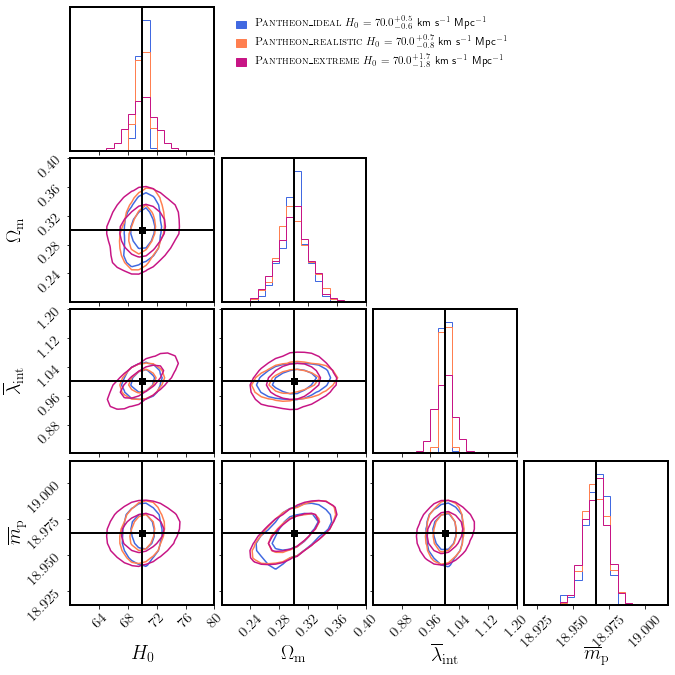

In [48]:

save_plot = False

samples_plot_list = [mcmc_samples_glSNe_pantheon_00, mcmc_samples_glSNe_pantheon_02, mcmc_samples_glSNe_pantheon_10]
label_text_list = [lable_glSNe_pantheon_00, lable_glSNe_pantheon_02, lable_glSNe_pantheon_10]
center_on_truth = True
indices_plot = [0, 1, 2, 3]


fig = plot_forecasts(samples_plot_list, label_text_list, indices_plot, center_on_truth=center_on_truth)

if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/forecast_posteriors_pantheon.pdf', dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format='pdf',
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None, metadata=None)
fig.show()



/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  from ipykernel import kernelapp as app
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


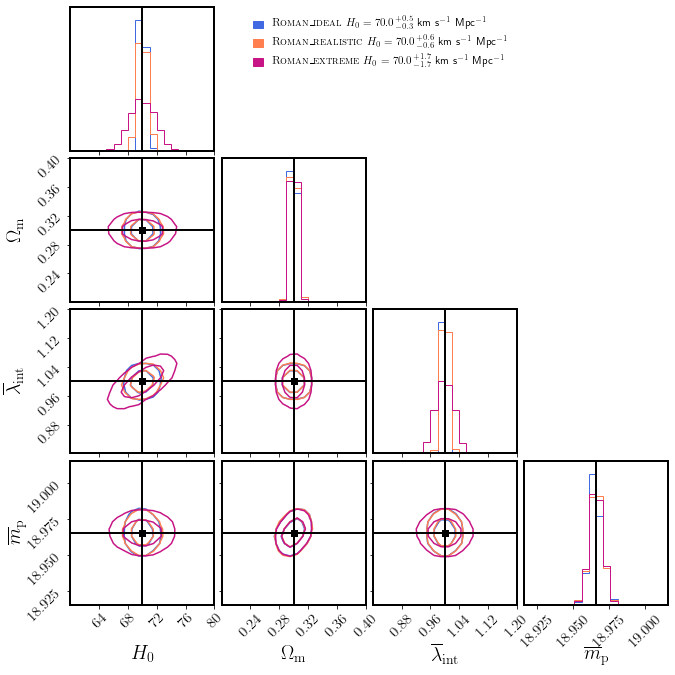

In [47]:
save_plot = False

samples_plot_list = [mcmc_samples_glSNe_roman_00, mcmc_samples_glSNe_roman_02, mcmc_samples_glSNe_roman_10]
label_text_list = [lable_glSNe_roman_00, lable_glSNe_roman_02, lable_glSNe_roman_10]
center_on_truth = True
indices_plot = [0, 1, 2, 3]


fig = plot_forecasts(samples_plot_list, label_text_list, indices_plot, center_on_truth=center_on_truth)

if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/forecast_posteriors_roman.pdf', dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format='pdf',
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None, metadata=None)
fig.show()

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


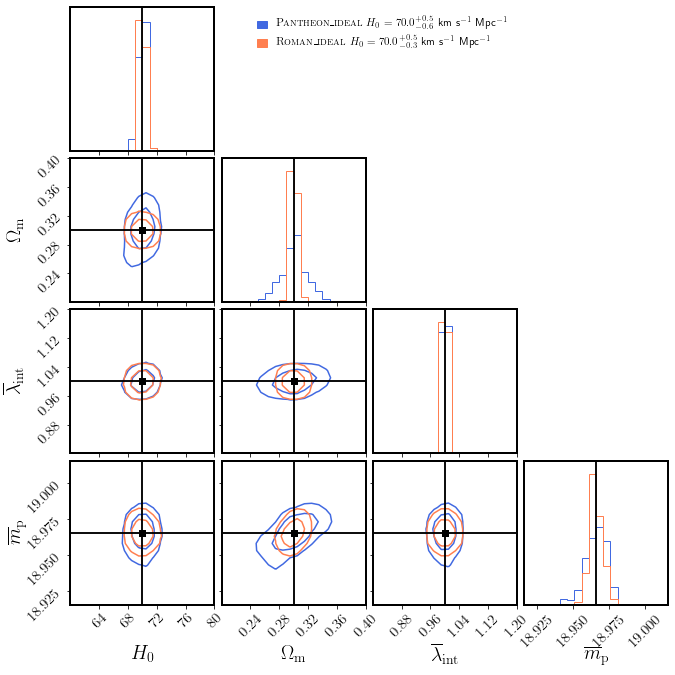

In [44]:
save_plot = False

samples_plot_list = [mcmc_samples_glSNe_pantheon_00, mcmc_samples_glSNe_roman_00]
label_text_list = [lable_glSNe_pantheon_00, lable_glSNe_roman_00]
center_on_truth = True
indices_plot = [0, 1, 2, 3]


fig = plot_forecasts(samples_plot_list, label_text_list, indices_plot, center_on_truth=center_on_truth)

if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/forecast_posteriors_pantheon_future_00.pdf', dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format='pdf',
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None, metadata=None)
fig.show()

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


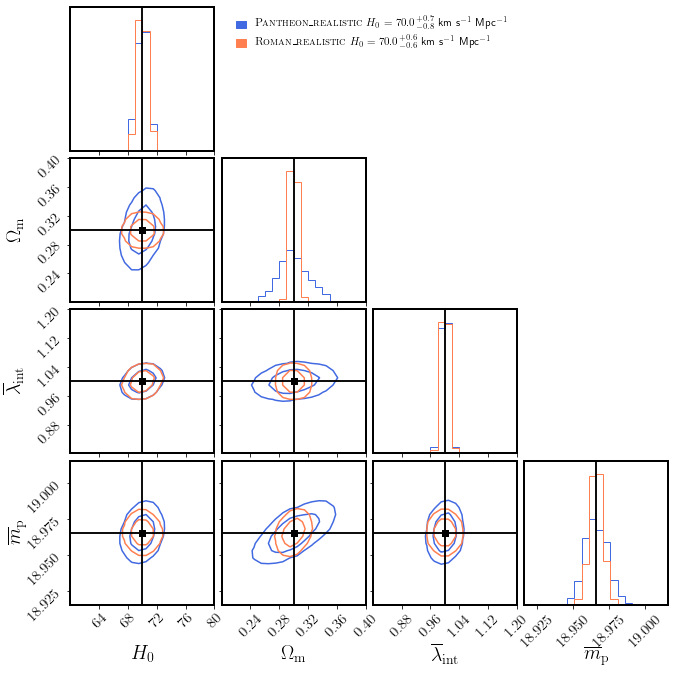

In [45]:
save_plot = False

samples_plot_list = [mcmc_samples_glSNe_pantheon_02, mcmc_samples_glSNe_roman_02]
label_text_list = [lable_glSNe_pantheon_02, lable_glSNe_roman_02]
center_on_truth = True
indices_plot = [0, 1, 2, 3]


fig = plot_forecasts(samples_plot_list, label_text_list, indices_plot, center_on_truth=center_on_truth)

if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/forecast_posteriors_pantheon_roman_03.pdf', dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format='pdf',
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None, metadata=None)
fig.show()

## make results table

In [46]:
# make table entries with percentages

fmt = "{{0:{0}}}".format(".1f").format

def percent_error(sample, param_index=0):
    """
    computes percent error in string format for the first parameter of the i'th parameter of an MCMC chain
    """
    return str(fmt(np.std(sample[:, param_index])/np.mean(sample[:, param_index])*100)) + '\% '


error_glSNe_fix_mst = percent_error(mcmc_samples_glSNe_fix_mst)
error_glSNe_fix_mst_roman = percent_error(mcmc_samples_glSNe_fix_mst_roman)

error_glSNe_pantheon_00 = percent_error(mcmc_samples_glSNe_pantheon_00)
error_glSNe_pantheon_00_lambda = percent_error(mcmc_samples_glSNe_pantheon_00, param_index=2)
error_glSNe_pantheon_02 = percent_error(mcmc_samples_glSNe_pantheon_02)
error_glSNe_pantheon_02_lambda = percent_error(mcmc_samples_glSNe_pantheon_02, param_index=2)
error_glSNe_pantheon_10 = percent_error(mcmc_samples_glSNe_pantheon_10)
error_glSNe_pantheon_10_lambda = percent_error(mcmc_samples_glSNe_pantheon_10, param_index=2)

error_glSNe_roman_00 = percent_error(mcmc_samples_glSNe_roman_00)
error_glSNe_roman_00_lambda = percent_error(mcmc_samples_glSNe_roman_00, param_index=2)
error_glSNe_roman_02 = percent_error(mcmc_samples_glSNe_roman_02)
error_glSNe_roman_02_lambda = percent_error(mcmc_samples_glSNe_roman_02, param_index=2)
error_glSNe_roman_10 = percent_error(mcmc_samples_glSNe_roman_10)
error_glSNe_roman_10_lambda = percent_error(mcmc_samples_glSNe_roman_10, param_index=2)




print(r'Scenario &  SNe sample  & $\sigma_{\rm eff, std}(m)$ & $\delta \overline{\lambda}_{\rm int}/\overline{\lambda}_{\rm int}$ & $\delta H_0/H_0$  \\ ')
print(r'\hline')
print(r'\hline')
print(lable_glSNe_fix_mst + ' & Pantheon  & - & ' + '$=0$' + ' & ' + error_glSNe_fix_mst  +' \\\ ' )
print(lable_glSNe_pantheon_00 + ' & Pantheon  & 0.0  & ' + error_glSNe_pantheon_00_lambda + ' & ' + error_glSNe_pantheon_00  +' \\\ ' )
print(lable_glSNe_pantheon_02 + ' & Pantheon  & 0.2  & ' + error_glSNe_pantheon_02_lambda + ' & ' + error_glSNe_pantheon_02  +' \\\ ' )
print(lable_glSNe_pantheon_10 + ' & Pantheon  & 1.0  & ' + error_glSNe_pantheon_10_lambda + ' & ' + error_glSNe_pantheon_10  +' \\\ ' )
#print(r'\hline')
print(lable_glSNe_fix_mst_roman + ' & Roman SNe & - & ' + '$=0$' + ' & ' + error_glSNe_fix_mst_roman  +' \\\ ' )
print(lable_glSNe_roman_00 + ' & Roman SNe & 0.0  & ' + error_glSNe_roman_00_lambda + ' & ' + error_glSNe_roman_00  +' \\\ ' )
print(lable_glSNe_roman_02 + ' & Roman SNe & 0.2  & ' + error_glSNe_roman_02_lambda + ' & ' + error_glSNe_roman_02  +' \\\ ' )
print(lable_glSNe_roman_10 + ' & Roman SNe & 1.0  & ' + error_glSNe_roman_10_lambda + ' & ' + error_glSNe_roman_10  +' \\\ ' )
print(r'\hline')



print(r'Scenario &  SNe sample  & $\sigma_{\rm eff, std}(m)$ & $\sigma_{\rm eff, ml}(m)$ & $\delta H_0/H_0$  \\ ')
print(r'\hline')
print(r'\hline')
print(lable_glSNe_fix_mst + ' & Pantheon  & - & - &  ' + error_glSNe_fix_mst  +' \\\ ' )
print(lable_glSNe_pantheon_00 + ' & Pantheon  & 0.0 & 1.0 & ' + error_glSNe_pantheon_00  +' \\\ ' )
print(lable_glSNe_pantheon_02 + ' & Pantheon  & 0.2 & 1.0  & ' + error_glSNe_pantheon_02  +' \\\ ' )
print(lable_glSNe_pantheon_10 + ' & Pantheon  & 1.0 & 1.0  & ' + error_glSNe_pantheon_10  +' \\\ ' )
#print(r'\hline')
print(lable_glSNe_fix_mst_roman + ' & Roman SNe & - & - & ' + error_glSNe_fix_mst_roman  +' \\\ ' )
print(lable_glSNe_roman_00 + ' & Roman SNe & 0.0 & 1.0  & ' + error_glSNe_roman_00  +' \\\ ' )
print(lable_glSNe_roman_02 + ' & Roman SNe & 0.2 & 1.0  & ' + error_glSNe_roman_02  +' \\\ ' )
print(lable_glSNe_roman_10 + ' & Roman SNe & 1.0 & 1.0  & ' + error_glSNe_roman_10  +' \\\ ' )
print(r'\hline')




Scenario &  SNe sample  & $\sigma_{\rm eff, std}(m)$ & $\delta \overline{\lambda}_{\rm int}/\overline{\lambda}_{\rm int}$ & $\delta H_0/H_0$  \\ 
\hline
\hline
 \textsc{Pantheon\_no\_mst} & Pantheon  & - & $=0$ & 0.6\%  \\ 
 \textsc{Pantheon\_ideal} & Pantheon  & 0.0  & 0.8\%  & 0.8\%  \\ 
 \textsc{Pantheon\_realistic} & Pantheon  & 0.2  & 1.0\%  & 1.1\%  \\ 
 \textsc{Pantheon\_extreme} & Pantheon  & 1.0  & 2.5\%  & 2.5\%  \\ 
 \textsc{Roman\_no\_mst} & Roman SNe & - & $=0$ & 0.6\%  \\ 
 \textsc{Roman\_ideal} & Roman SNe & 0.0  & 0.5\%  & 0.6\%  \\ 
 \textsc{Roman\_realistic} & Roman SNe & 0.2  & 0.9\%  & 0.9\%  \\ 
 \textsc{Roman\_extreme} & Roman SNe & 1.0  & 2.4\%  & 2.4\%  \\ 
\hline
Scenario &  SNe sample  & $\sigma_{\rm eff, std}(m)$ & $\sigma_{\rm eff, ml}(m)$ & $\delta H_0/H_0$  \\ 
\hline
\hline
 \textsc{Pantheon\_no\_mst} & Pantheon  & - & - &  0.6\%  \\ 
 \textsc{Pantheon\_ideal} & Pantheon  & 0.0 & 1.0 & 0.8\%  \\ 
 \textsc{Pantheon\_realistic} & Pantheon  & 0.2 & 1.0  & 1.